In [4]:
import os

from pool.utils import model_utils
from pool.model import DualCRBMRelu, PoolCRBMRelu
import pool.analysis.analysis_methods as am
import pool.analysis.analysis_methods_crbm as amc

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import json
import math
import subprocess as sp
import matplotlib.image as mpimg

ModuleNotFoundError: No module named 'pool'

In [2]:
if not os.path.exists("./generated"):
    os.mkdir("./generated")

# Load Model and Data

### Give Model Location and Runfile Location

In [3]:
# Directory of Stored CRBMs
mdir = "/home/jonah/PycharmProjects/pool_harmonium/datasets/cov/trained/"
runfile = "/home/jonah/PycharmProjects/pool_harmonium/datasets/cov/run_files/enriched_dual.yaml"

config = model_utils.load_run(runfile)
rounds = [config["name"]]

train_fastas = config["fasta_file"]
if type(train_fastas) is list:
    data_keys = [x.split(".")[0] for x in train_fastas]
else:
    data_keys = [train_fastas.split(".")[0]]

### Load CRBM

In [4]:
# Get's checkpoint and directory for latest version of the trained model
checkp, version_dir = am.get_checkpoint_path(rounds[0], model_dir=mdir) #, version=25)

# load crbm
ncrbm = DualCRBMRelu.load_from_checkpoint(checkp)
ncrbm.eval()

DualCRBMRelu()

### Generate PDF of all Weights used by the CRBM

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


KeyError: '$\\boxminus$'

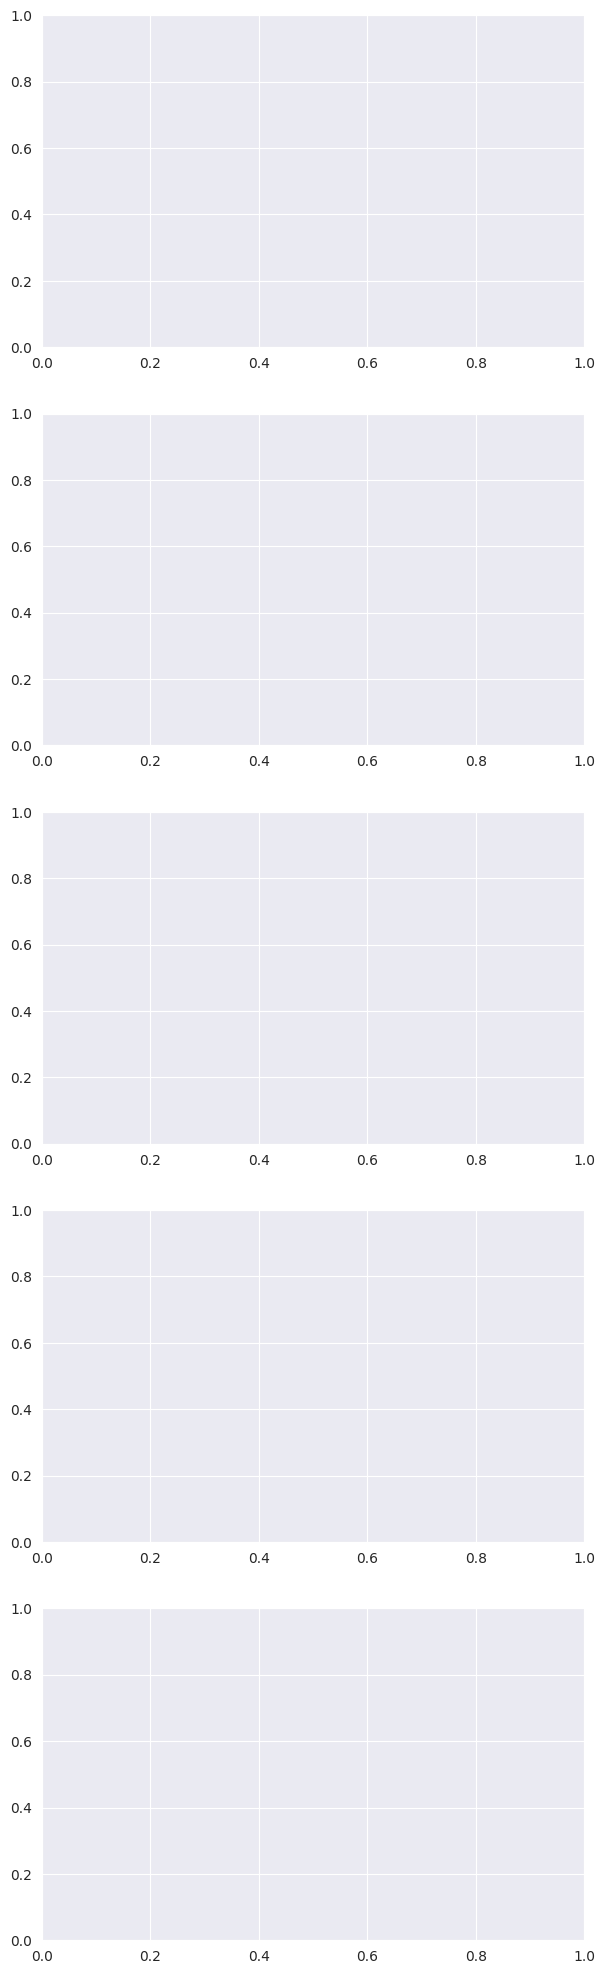

In [5]:
# Generate Weight PDF inside mdir/version_dir
# order weights by descending l2 norm
model_utils.all_weights(ncrbm, name=version_dir + rounds[0] + "_unordered", order_weights=False)
model_utils.all_weights(ncrbm, name=version_dir + rounds[0] + "_ordered", order_weights=True)

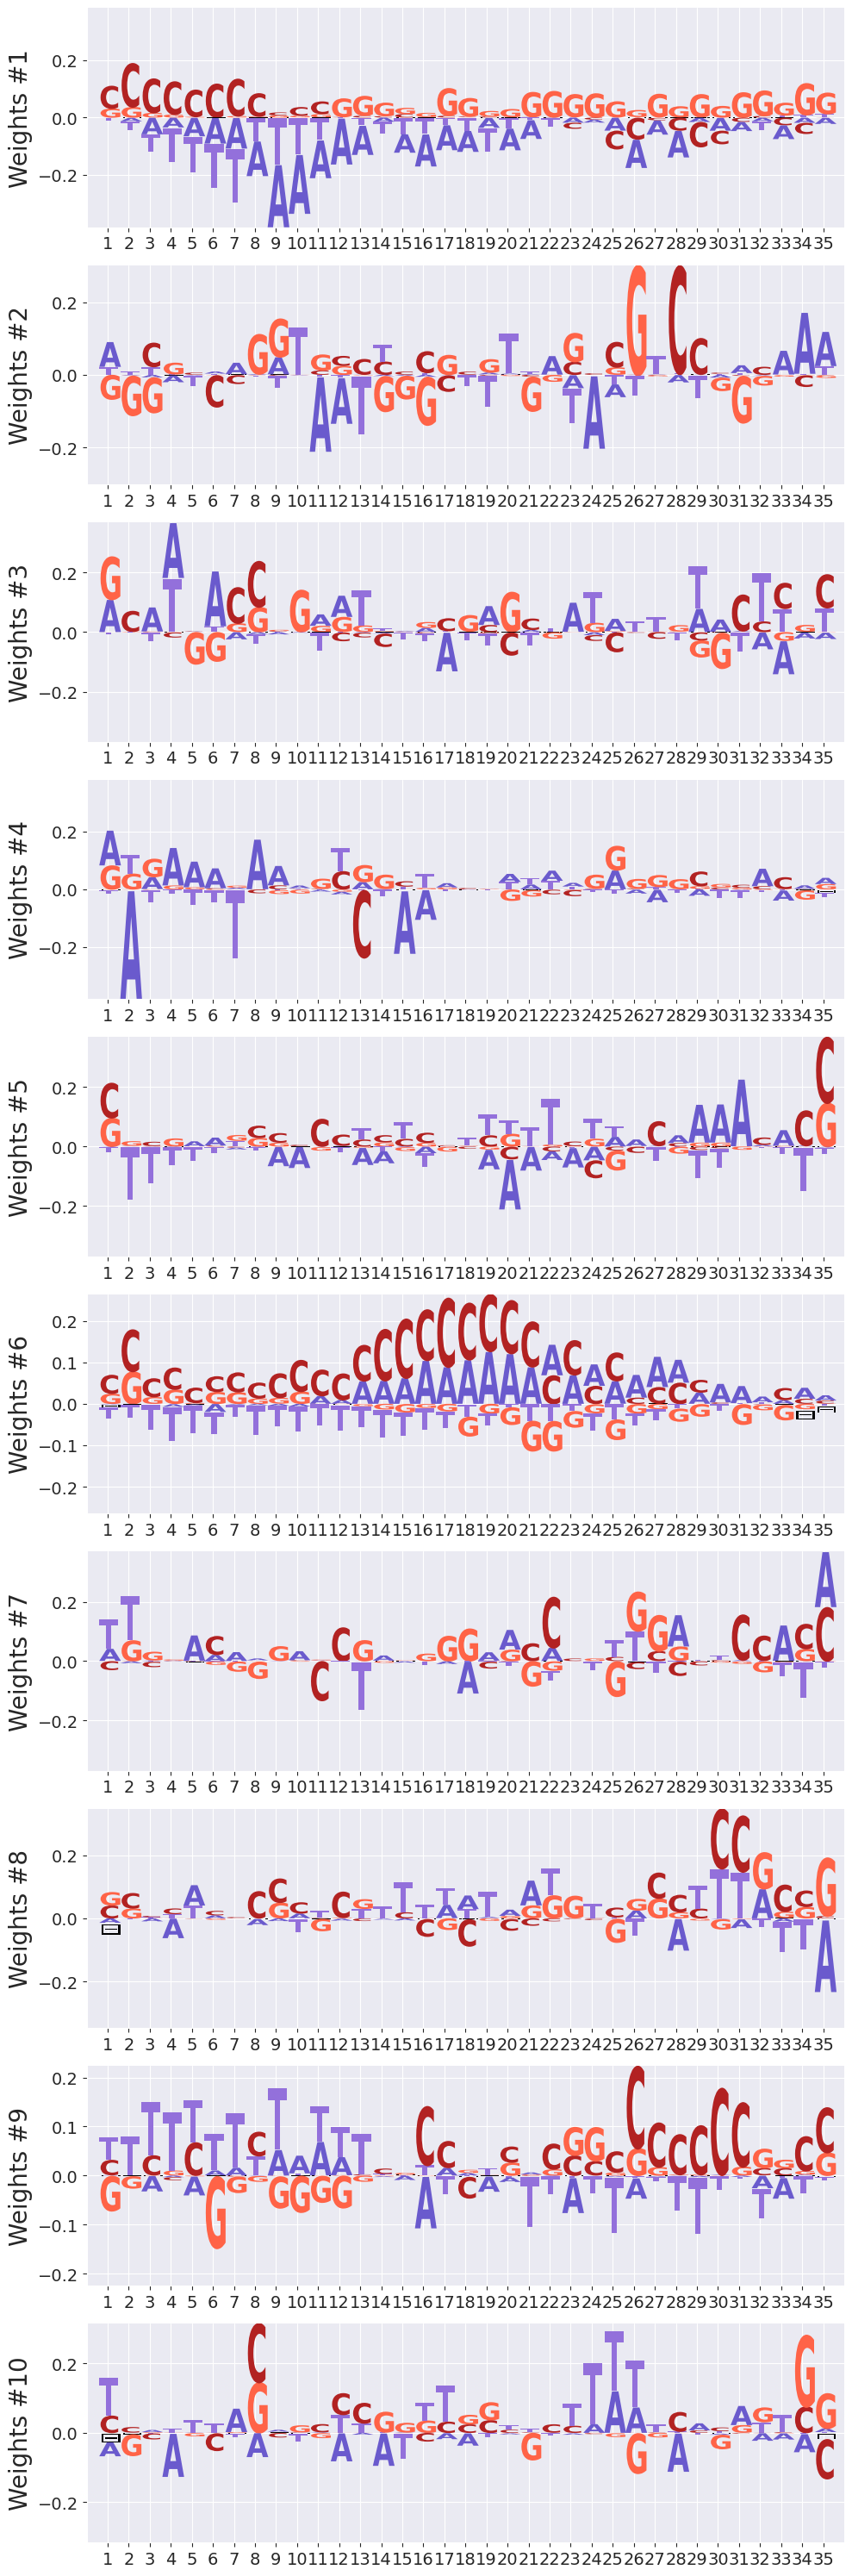

In [6]:
# View individual weight

am.view_weights_crbm(ncrbm, ncrbm.hidden_convolution_keys[0], sort="top", selected=list(range(10)), molecule="dna")

### Load Data, and assign to train, val, test

In [4]:
# Put all data into dictionary
# dir(s) is location of fasta file used during training
# optional assignment for
all_data = am.fetch_data(data_keys, dir="../", assignment_function=None, threads=12)

# Assign data to train, valid, testy under round column
# Generated during model training
with open(version_dir + "dataset_indices.json", "r") as json_file:
    di = json.load(json_file)

print("Total Sequences:", all_data.index.__len__())

new_rounds = np.full((all_data.index.__len__()), "valid")
new_rounds[di["train_indices"]] = "train"
new_rounds[di["test_indices"]] = "testy"

all_data["round"] = new_rounds.tolist()

Process Time 0.00860452651977539
Total Sequences: 14714


# Get Likelihoods From Model

In [8]:
# calculate likelihoods and fitness values
import torch
# device = torch.device("cpu")
# ncrbm.to(device)
# ncrbm.eval()

am.generate_likelihoods(["train", "valid", "testy"], ncrbm, all_data, f"cov_likelihoods")
am.generate_likelihoods(["train", "valid", "testy"], ncrbm, all_data, f"cov_likelihoods_ind", individual_hiddens=True)


In [5]:
# read in generated likelihoods
ncrbm_likelihoods = am.get_likelihoods("./generated/cov_likelihoods.json")
ncrbm_likelihoods_ind = am.get_likelihoods("./generated/cov_likelihoods_ind.json")

In [6]:
from copy import copy
train_data = copy(all_data[all_data["round"] == "train"])
val_data = copy(all_data[all_data["round"] == "valid"])
test_data = copy(all_data[all_data["round"] == "testy"])

train_data["likelihood"] = ncrbm_likelihoods["likelihoods"]["train"]
val_data["likelihood"] = ncrbm_likelihoods["likelihoods"]["valid"]
test_data["likelihood"] = ncrbm_likelihoods["likelihoods"]["testy"]

train_data["likelihood_ind"] = ncrbm_likelihoods_ind["likelihoods"]["train"]
val_data["likelihood_ind"] = ncrbm_likelihoods_ind["likelihoods"]["valid"]
test_data["likelihood_ind"] = ncrbm_likelihoods_ind["likelihoods"]["testy"]

### Plot Likelihoods of Train, Test, and Val

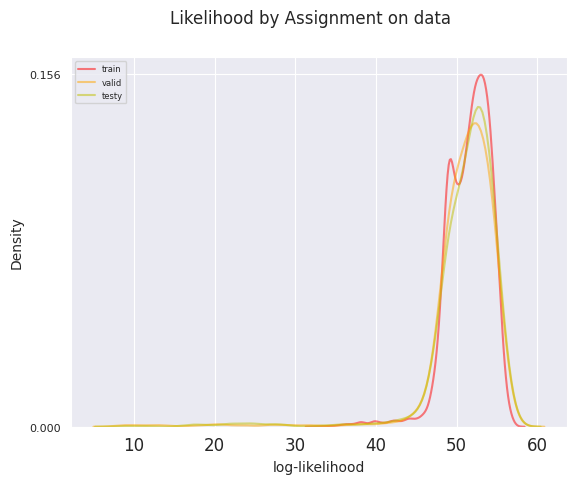

In [7]:
rs_list = [["train"], ["valid"], ["testy"]]
rs_list_t = [list(x) for x in zip(*rs_list)]

am.plot_likelihoods_multiple(ncrbm_likelihoods["likelihoods"], rs_list_t, rs_list_t, title=f"Likelihood by Assignment on data", xlim=None, legend_font_size=6)

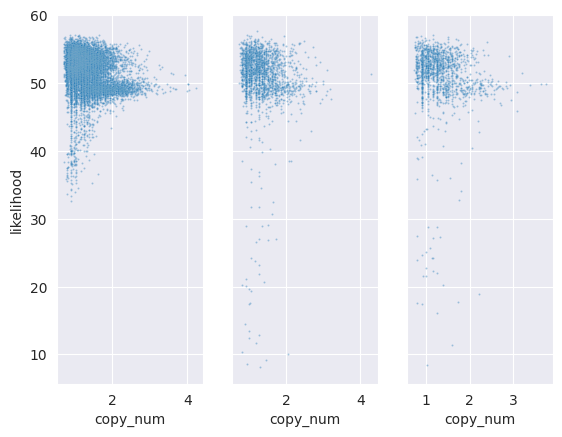

In [8]:
# Compare copy_num (Enrichment Value) vs Model Likelihood
fig, axs = plt.subplots(1, 3, sharey=True)
sns.scatterplot(data=train_data, x="copy_num", y="likelihood", ax=axs[0], alpha=0.4, s=2.0)
sns.scatterplot(data=val_data, x="copy_num", y="likelihood", ax=axs[1], alpha=0.4, s= 2.0)
sns.scatterplot(data=test_data, x="copy_num", y="likelihood", ax=axs[2], alpha=0.4, s= 2.0)
plt.show()

Text(0.5, 0, 'Average Log Enrichment')

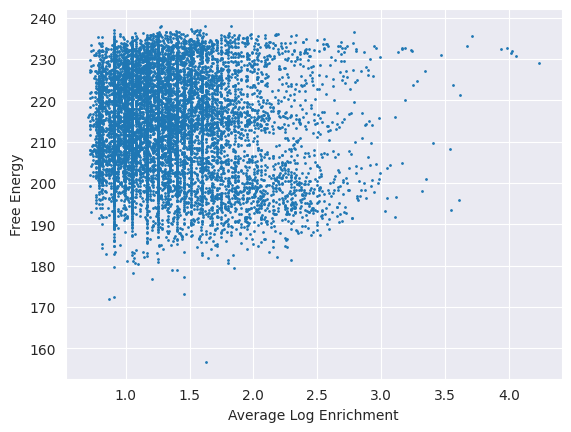

In [16]:
################### possibly remove

beta, W = model_utils.get_beta_and_W(ncrbm, hidden_key=ncrbm.hidden_convolution_keys[0])
order = np.argsort(beta)[::-1]

train_ind = np.asarray(train_data["likelihood_ind"].to_list())

remove = [0, 5, 15, 21, 28, 41, 47]

fixed_likeli = train_ind.sum(axis=1)
for r in remove:
    fixed_likeli -= train_ind[:, order[r]]

fig, ax = plt.subplots(1, 1)
plt.scatter(train_data.copy_num.to_list(), fixed_likeli, s=1)
plt.ylabel("Free Energy")
plt.xlabel("Average Log Enrichment")

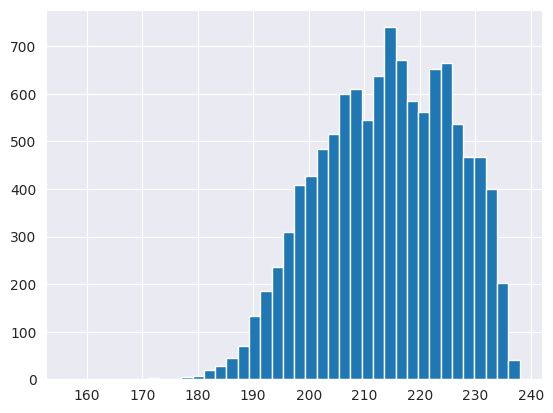

In [17]:
################### possibly remove
plt.hist(fixed_likeli, bins=40)
plt.show()

[Mon Aug 14 22:45:53 2023] Summary: 
[Mon Aug 14 22:45:53 2023]    Input       :   tmp.csv
[Mon Aug 14 22:45:53 2023]    Background  :   local
[Mon Aug 14 22:45:53 2023]    Output      :   ./generated/peak1_likeli_train.*
[Mon Aug 14 22:45:53 2023]    alphabet    :   ACDEFGHIKLMNPQRSTVWYU-
[Mon Aug 14 22:45:53 2023]    min_kmer    :   1
[Mon Aug 14 22:45:53 2023]    max_kmer    :   4
[Mon Aug 14 22:45:53 2023]    min_shift   :   0
[Mon Aug 14 22:45:53 2023]    max_shift   :   0
[Mon Aug 14 22:45:53 2023]    p           :   1.010000
[Mon Aug 14 22:45:53 2023]    start at    :   1
[Mon Aug 14 22:45:53 2023] 4306 sequences loaded from tmp.csv
[Mon Aug 14 22:45:53 2023] making frequency logo...
[Mon Aug 14 22:45:53 2023] making information content logo...
[Mon Aug 14 22:45:53 2023] Summary: 
[Mon Aug 14 22:45:53 2023]    Input       :   tmp.csv
[Mon Aug 14 22:45:53 2023]    Background  :   local
[Mon Aug 14 22:45:53 2023]    Output      :   ./generated/peak2_likeli_train.*
[Mon Aug 14 22:4

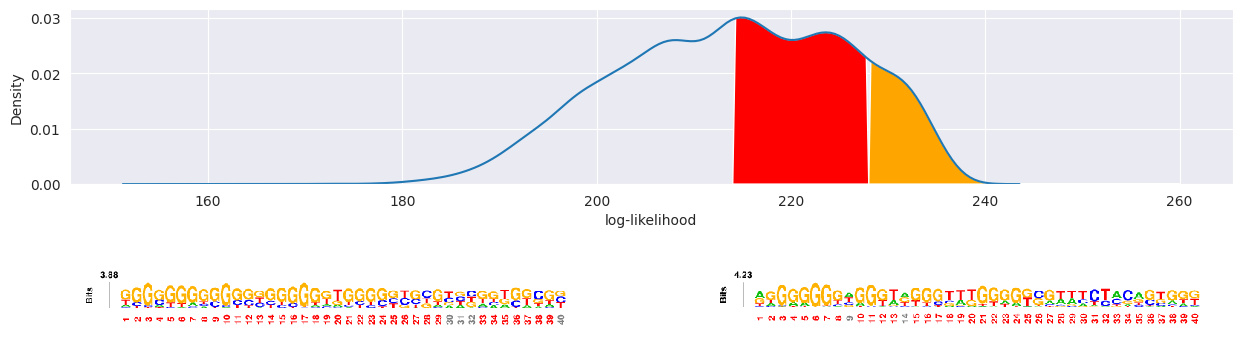

In [18]:
################### possibly remove
am.multi_peak_seq_log_fig(all_data, {"train": fixed_likeli.tolist()}, "train", [[214, 228], [228, 260]]) #[[0, 118], [118, 127], [127, 134], [134, 140], [140, 160]])

In [20]:
all_data["eval_lik"] = -100
all_data.loc[all_data["round"] == "train", "eval_lik"] = fixed_likeli.tolist()
ads = all_data.sort_values("eval_lik", ascending=False, inplace=False)
ads

sequence  copy_num  round assignment  \
1827   AAGGAGGGTAGGTAGTGCTTGGTACGGAAACTCCGCCGAT  1.824406  train        N/A   
6465   AAGGAGTGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT  1.275896  train        N/A   
2975   AAGGAGGGTAGGTAGTGCTTGGTAGTGAAACTCCGCCGAT  1.618881  train        N/A   
6516   AAGGAGGGTAGGTAGTTCTTGGTAGGGAAACTCCGCCGAT  1.266607  train        N/A   
3976   AAGGAGGGTAGGTCGTGCTTGGTAGGGAAACTCCGCCGAT  1.510101  train        N/A   
...                                         ...       ...    ...        ...   
7840   TGGGGGGGGGCGGGGGGGGTGCGCGTTCGAGGGGTCGCAG  1.189447  testy        N/A   
7837   AGGCTTATCGTCAGGGGGGTGTGTCCGGGTTTGGGGTCGT  1.190561  valid        N/A   
7836   AGGCTTATCGCCCGGGGGGTGGGCCGGGGTTTGGGGTCGT  1.191076  testy        N/A   
7835   GGGCGGGGGGCGGCCCGGGTGCTCGTTCGAGGGGTCGCAG  1.191076  valid        N/A   
14713  GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAGCC  0.704572  valid        N/A   

         eval_lik  
1827   237.997616  
6465   237.937388  
2975   237.935199  
6516   237.707055  
3976   237.148378  
...           ...  
7840  -100.000000  
7837  -100.000000  
7836  -100.000000  
7835  -100.000000  
14713 -100.000000  

[14714 rows x 5 columns]

In [16]:
all_data

sequence  copy_num  round assignment  \
0      CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG  4.297475  valid        N/A   
1      CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGGTG  4.238403  testy        N/A   
2      CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG  4.057590  train        N/A   
3      CCATTGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG  4.028253  train        N/A   
4      CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGAT  4.017087  train        N/A   
...                                         ...       ...    ...        ...   
14709  GGGCGGCGCCCCGCGGGGCCACACCAAAACACGTTCAACT  0.717437  valid        N/A   
14710  CGGCTTATGGTCCGGGGGGGGGGGCCGGGTGCGGGGTCGT  0.717437  valid        N/A   
14711  GGGCGGGAGGGAGGGGGGCCACACCGAAACACGTTCAGCT  0.714356  train        N/A   
14712  GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAGCT  0.707206  train        N/A   
14713  GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAGCC  0.704572  train        N/A   

         eval_lik  
0     -100.000000  
1     -100.000000  
2      156.951372  
3      157.043643  
4      155.205274  
...           ...  
14709 -100.000000  
14710 -100.000000  
14711  127.595564  
14712  127.931125  
14713  125.664624  

[14714 rows x 5 columns]

In [22]:
################### possibly remove
hidden_indices = [[i for i in range(ncrbm.convolution_topology[key]["number"])] for key in ncrbm.hidden_convolution_keys]
remove_these = [remove]

for i in range(len(hidden_indices)):
    for r in remove_these[i]:
        hidden_indices[i].remove(order[r])

eval_ncrbm = model_utils.extract_cluster_crbm_pool(ncrbm, hidden_indices)

In [18]:
am.generate_likelihoods(["train"], eval_ncrbm, all_data, "cov_eval_likelihoods")

### Compare to Raw Sequencing Data

In [23]:
raw_data = am.fetch_data([f"r{i}" for i in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]], dir="../raw_rounds/", assignment_function=None, threads=12, normalize_counts=True, molecule="dna")

Process Time 0.9710133075714111
Process Time 0.37722182273864746
Process Time 1.7043673992156982
Process Time 1.1008257865905762
Process Time 1.9296343326568604
Process Time 0.699946403503418
Process Time 0.18401813507080078
Process Time 0.4723997116088867
Process Time 0.2493455410003662
Process Time 0.5088717937469482


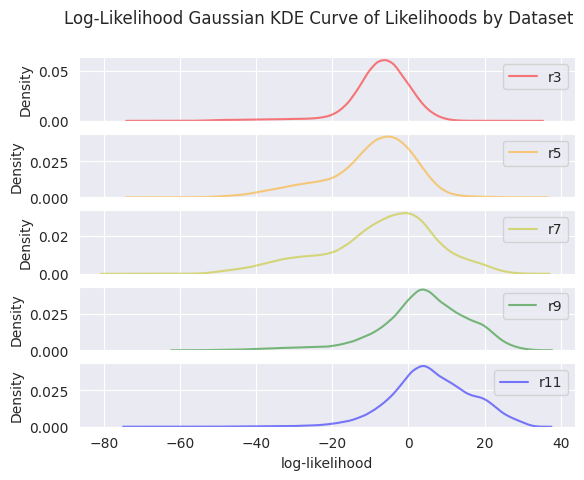

In [24]:
am.generate_likelihoods([f"r{i}" for i in [3, 5, 7, 9, 11]], eval_ncrbm, raw_data, f"cov_eval_raw_likelihoods")
ncrbm_raw_likelihoods = am.get_likelihoods("./generated/cov_eval_raw_likelihoods.json")


labels = [f"r{i}" for i in [3, 5, 7, 9, 11]]
weights = [raw_data[raw_data["round"] == l]["copy_num"].to_numpy() for l in labels]
am.plot_likelihoods(ncrbm_raw_likelihoods["likelihoods"], labels, labels, xlim=None, cdf=False, weights=None)

In [25]:
am.generate_likelihoods(["train", "valid", "testy"], eval_ncrbm, all_data, f"cov_likelihoods_eval")

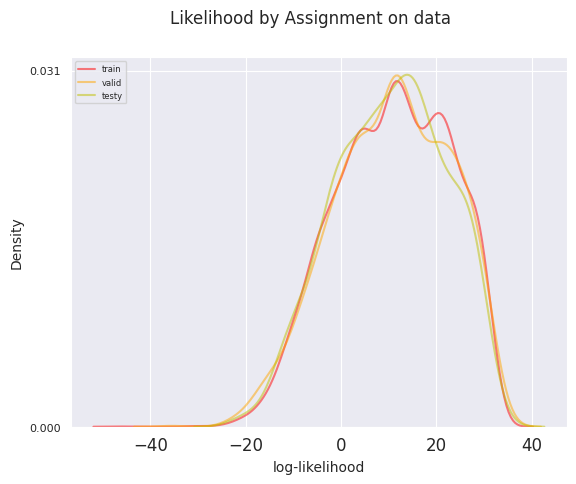

In [8]:
# read in generated likelihoods
eval_likelihoods = am.get_likelihoods("./generated/cov_likelihoods_eval.json")

from copy import copy
train_data["eval_likelihood"] = eval_likelihoods["likelihoods"]["train"]
val_data["eval_likelihood"] = eval_likelihoods["likelihoods"]["valid"]
test_data["eval_likelihood"] = eval_likelihoods["likelihoods"]["testy"]

all_data["eval_likelihood"] = -100
all_data.loc[all_data["round"] == "train", "eval_likelihood"] = eval_likelihoods["likelihoods"]["train"]
all_data.loc[all_data["round"] == "valid", "eval_likelihood"] = eval_likelihoods["likelihoods"]["valid"]
all_data.loc[all_data["round"] == "testy", "eval_likelihood"] = eval_likelihoods["likelihoods"]["testy"]


rs_list = [["train"], ["valid"], ["testy"]]
rs_list_t = [list(x) for x in zip(*rs_list)]

am.plot_likelihoods_multiple(eval_likelihoods["likelihoods"], rs_list_t, rs_list_t, title=f"Likelihood by Assignment on data", xlim=None, legend_font_size=6)

In [27]:
ads2 = all_data.sort_values("eval_likelihood", ascending=False, inplace=False)

In [28]:
ads2.head(500)

sequence  copy_num  round assignment  \
1827   AAGGAGGGTAGGTAGTGCTTGGTACGGAAACTCCGCCGAT  1.824406  train        N/A   
6465   AAGGAGTGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT  1.275896  train        N/A   
2975   AAGGAGGGTAGGTAGTGCTTGGTAGTGAAACTCCGCCGAT  1.618881  train        N/A   
2308   AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCACCGATT  1.718356  testy        N/A   
6516   AAGGAGGGTAGGTAGTTCTTGGTAGGGAAACTCCGCCGAT  1.266607  train        N/A   
...                                         ...       ...    ...        ...   
2671   TCGCGGTGGTAGGGTAGGCAGTGCAGCGGTCTTATGATCA  1.674921  train        N/A   
2827   AGGAGGGTAGGTAGTGCTTGGTAGGGAAACCCCGCCGATT  1.639772  train        N/A   
9216   GGGCGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT  1.082648  train        N/A   
11221  ATGGGGGGCGGGTAGGTTATGGGGTCGTTTCTACAGTGGG  0.985190  train        N/A   
11486  GGGGGGGTTGGGTTGGGTATGGGGTCGTTTCTACAGTGGG  0.951613  train        N/A   

         eval_lik  eval_likelihood  
1827   237.997616        34.729767  
6465   237.937388        34.687805  
2975   237.935199        34.678955  
2308  -100.000000        34.542709  
6516   237.707055        34.426544  
...           ...              ...  
2671   233.099393        29.893799  
2827   233.064746        29.888962  
9216   233.053400        29.886032  
11221  233.049136        29.880814  
11486  232.990359        29.879684  

[500 rows x 6 columns]

# Clustering Data

In [9]:
from sklearn.decomposition import PCA
import rbm_torch.analysis.clustering_methods as  cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

train_vout = ncrbm.compute_output_v(amc.dataframe_to_input(train_data, ncrbm.alphabet, ncrbm.v_num, ncrbm.q))

train_vout = torch.concat(train_vout, dim=1)


scaler = StandardScaler()
# X = scaler.fit_transform(train_vout.detach().numpy())
X = train_vout.detach().numpy()

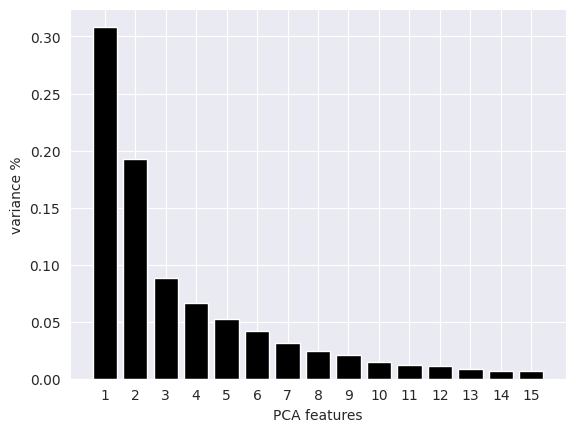

In [8]:
cm.pca_component_check(X, components=15)

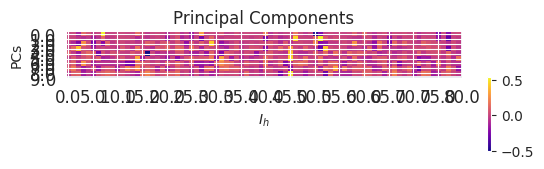

In [10]:
pca = PCA(n_components=9)
principal_components = pca.fit_transform(X)
PCA_components_pd = pd.DataFrame(principal_components)
components = pca.components_
cm.view_components(components)

/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

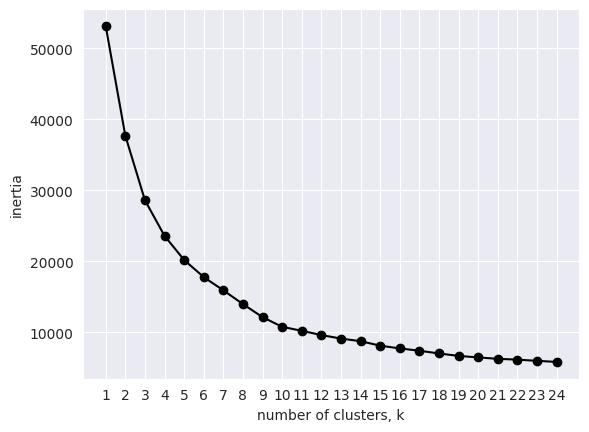

In [40]:
from sklearn.cluster import KMeans

ks = range(1, 25)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(principal_components)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [11]:
# Elbow Point is at 5 so we will run it for 5 clusters
clusters = 10
dataset = train_data
kmeans_pca = KMeans(n_clusters=clusters, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([dataset.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
pcs = principal_components.shape[1]
df_pca_kmeans.columns.values[-pcs:] = [f"Component {i}" for i in range(1, pcs+1)]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({i:i+1 for i in range(clusters)})

/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


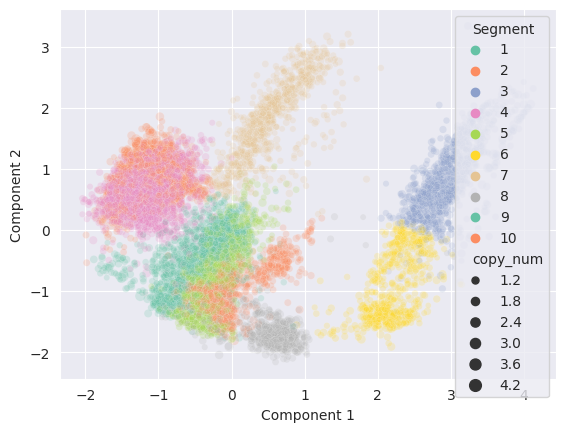

In [20]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", size="copy_num", alpha=0.2, s=0.1, palette="Set2")
plt.show()

[Sun Aug 27 13:51:10 2023] Summary: 
[Sun Aug 27 13:51:10 2023]    Input       :   tmp.csv
[Sun Aug 27 13:51:10 2023]    Background  :   local
[Sun Aug 27 13:51:10 2023]    Output      :   ./generated/m1_pcak_sw_c1_seqlogo.*
[Sun Aug 27 13:51:10 2023]    alphabet    :   ACDEFGHIKLMNPQRSTVWYU-
[Sun Aug 27 13:51:10 2023]    min_kmer    :   1
[Sun Aug 27 13:51:10 2023]    max_kmer    :   4
[Sun Aug 27 13:51:10 2023]    min_shift   :   0
[Sun Aug 27 13:51:10 2023]    max_shift   :   0
[Sun Aug 27 13:51:10 2023]    p           :   1.010000
[Sun Aug 27 13:51:10 2023]    start at    :   1
[Sun Aug 27 13:51:10 2023] 830 sequences loaded from tmp.csv
[Sun Aug 27 13:51:10 2023] making frequency logo...
[Sun Aug 27 13:51:11 2023] making information content logo...
[Sun Aug 27 13:51:11 2023] Summary: 
[Sun Aug 27 13:51:11 2023]    Input       :   tmp.csv
[Sun Aug 27 13:51:11 2023]    Background  :   local
[Sun Aug 27 13:51:11 2023]    Output      :   ./generated/m1_pcak_sw_c2_seqlogo.*
[Sun Aug 27

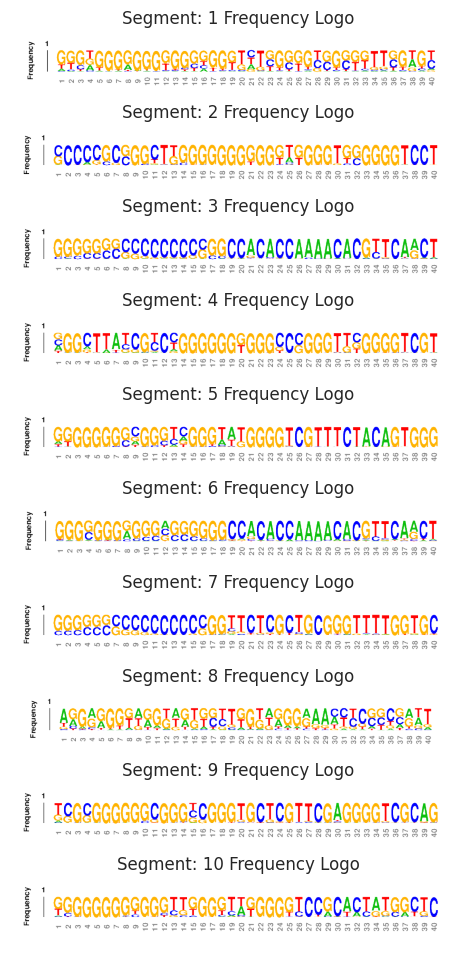

In [14]:
segments = [i for i in range(1, clusters+ 1)]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"m1_pcak_sw_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    # pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"m1_pcak_sw_c{seg}_seqlogo", weight=True, outdir="./generated/"))

# Seq Logo showing Frequency of Each Nucleotide at each position
fig, axs = plt.subplots(len(segments), 1)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    # img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid].imshow(img1)
    # axs[rid][1].imshow(img2)
    axs[rid].axis("off")
    # axs[rid][1].axis("off")
    axs[rid].set_title(f"Segment: {r} Frequency Logo")
    # axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

In [118]:
np.dot(kmeans_pca.cluster_centers_[0][None, :], components)

array([[ 5.6063481e-02,  1.1389814e-01,  4.8565295e-01, -5.7582580e-02,
         1.2452602e-01,  2.0162553e-01, -1.2947237e-01, -2.8520814e-01,
        -8.0592513e-02,  6.3386850e-02,  1.6547631e-02,  9.0268236e-03,
        -9.4801478e-02, -5.1163796e-02,  9.5443361e-02,  1.0462747e-01,
        -4.1062075e-01, -1.0873572e-01,  2.6379492e-02, -1.5286058e-02,
         2.0778745e-01, -6.9643110e-03,  2.9215455e-02,  2.7107352e-01,
         6.6092394e-02,  2.2746028e-01, -6.6123217e-02, -1.7684233e-01,
        -1.2316680e-01, -3.4038445e-01,  2.7850736e-04, -8.8900521e-02,
         3.7593212e-02,  7.5630397e-02, -1.0102037e-03, -5.7809442e-02,
         5.8622874e-02,  7.0872039e-02, -9.2851058e-02, -5.3537078e-04,
        -1.0794672e-01,  1.1811966e-01,  2.4305829e-03,  2.3289788e-01,
        -7.5218938e-02,  7.7499557e-01, -4.8056734e-01, -9.7435154e-02,
         8.8384852e-02, -1.0016999e-02,  1.0857229e-01, -2.6475233e-01,
         4.1099766e-01, -1.0372212e-02,  2.8296079e-02,  5.87415

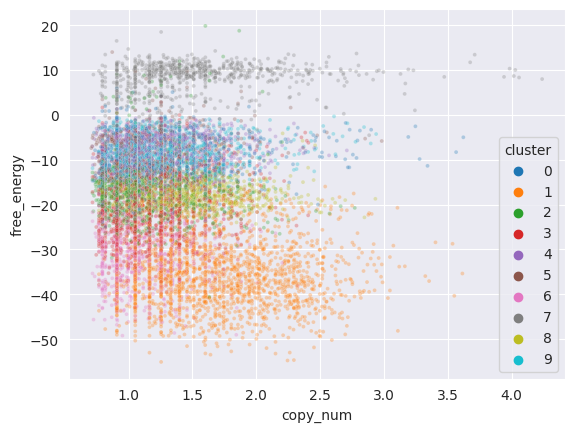

In [16]:
#from rbm_torch.utils.utils import extract_cluster_crbm_pool

component = 7
remove = np.where(components[component] < 0.2)[0].tolist()
beta, W = utils.get_beta_and_W(ncrbm, hidden_key=ncrbm.hidden_convolution_keys[0])
# order = np.argsort(beta)[::-1]

train_ind = np.asarray(train_data["likelihood_ind"].to_list())

# remove = [0, 5, 15, 21, 28, 41, 47]

# fixed_likeli = np.dot(train_ind, components[component])
fixed_likeli = (train_ind * np.dot(kmeans_pca.cluster_centers_[component][None, :], components)).sum(axis=1)
# for r in remove:
#     fixed_likeli -= train_ind[:, r]  #train_ind[:, order[r]]

# fig, ax = plt.subplots(1, 1)
# plt.scatter(train_data.copy_num.to_list(), fixed_likeli, s=1, c=np.array(am.supported_colors)[kmeans_pca.labels_])
tmp_df = pd.DataFrame({"sequence": train_data["sequence"].to_list(), "copy_num": train_data.copy_num.to_list(), "free_energy": fixed_likeli.tolist(), "cluster": kmeans_pca.labels_.tolist()})
sns.scatterplot(data=tmp_df, x="copy_num", y="free_energy", hue="cluster",  palette="tab10", s=8, alpha=0.3)
plt.show()
# plt.legend(kmeans_pca.labels_.tolist())
# plt.ylabel("Free Energy")
# plt.xlabel("Average Log Enrichment")

In [21]:
from rbm_torch.utils import data_prep as dp

os.mkdir("../clusters/")
os.mkdir("../clusters/configs/")
os.mkdir("../clusters/trained_crbms")

for i in range(clusters):
    seqs = tmp_df[tmp_df["cluster"] == i]["sequence"].tolist()
    cn = tmp_df[tmp_df["cluster"] == i]["copy_num"].tolist()
    dp.write_fasta(seqs, cn, f"../clusters/cluster{i}.fasta")


In [6]:
# os.mkdir("../clusters/configs/")
# os.mkdir("../clusters/trained_crbms")

ci = 7
clust_config = config
clust_config["fasta_file"] = '../clusters/cluster7.fasta'
clust_config["convolution_topology"]["hidden_25"]["number"] = 10
clust_config["epochs"] = 500

clust_run_data = run_data
clust_run_data['fasta_file'] = f'cluster{ci}.fasta'
clust_run_data['data_dir'] = '../clusters/'
clust_run_data['server_model_dir'] = '../clusters/trained_crbms/'
clust_run_data['local_model_dir'] = '/mnt/D1/globus/cov_trained_crbms/'
clust_run_data['model_name'] = f'pcrbm_relu_cluster{ci}'

clust_run_data['config'] = clust_config

run, con = utils.load_run(clust_run_data)

In [ ]:
from train import train

train(run)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../clusters/trained_crbms/pcrbm_relu_cluster7


Process Time 0.0018062591552734375


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type      | Params
-------------------------------------
0 | kl_div | KLDivLoss | 0     
-------------------------------------
2.2 K     Trainable params
20        Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 50/50 [00:06<00:00,  7.97it/s, v_num=0, ptl/free_energy_diff_step=-11.8, ptl/train_free_energy_step=-31.6, ptl/train_loss_step=-7.39]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  8.27it/s, v_num=0, ptl/free_energy_diff_step=-12.2, ptl/train_free_energy_step=-45.8, ptl/train_loss_step=-7.37, ptl/val_free_energy=-30.3, ptl/free_energy_diff_epoch=-10.2, ptl/train_free_energy_epoch=-20.2, ptl/train_loss_epoch=nan.0]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 50/50 [00:05<00:00,  8.39it/s, v_num=0, ptl/free_energy_diff_step=-10.7, ptl/train_free_energy_step=-62.4, ptl/train_loss_step=-6.51, ptl/val_free_energy=-44.3, ptl/free_energy_diff_epoch=-11.9, ptl/train_free_energy_epoch=-38.2, ptl/train_loss_epoch=nan.0]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 50/50 [00:06<00:00,  8.33it/s, v_num=0, ptl/free_energy_diff_step=-11.3, ptl/train_free_energy_step=-75.1, ptl/train_loss_step=-5.74, ptl/val_free_energy

In [8]:
# Directory of Stored CRBMs
mdir = "/home/jonah/PycharmProjects/phage_display_ML/datasets/cov/clusters/trained_crbms/"

rounds = [run["model_name"]]

train_fastas = run["fasta_file"]
if type(train_fastas) is list:
    data_keys = [x.split(".")[0] for x in train_fastas]
else:
    data_keys = [train_fastas.split(".")[0]]
### Load CRBM
# Get's checkpoint and directory for latest version of the trained model
checkp, version_dir = am.get_checkpoint_path(rounds[0], rbmdir=mdir)  #, version=25)

# load crbm
c7_crbm = pool_CRBM_relu.load_from_checkpoint(checkp)
c7_crbm.eval()

pool_CRBM_relu(
  (kl_div): KLDivLoss()
)

In [14]:
c7_data = am.fetch_data(data_keys, dir="../clusters/", molecule='dna')
c7_data.head()

Process Time 0.0026650428771972656


sequence  copy_num     round assignment
0  CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGGTG  4.238403  cluster7        N/A
1  CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG  4.057590  cluster7        N/A
2  CCATTGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG  4.028253  cluster7        N/A
3  CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGAT  4.017087  cluster7        N/A
4  CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGCTTGATG  3.983772  cluster7        N/A

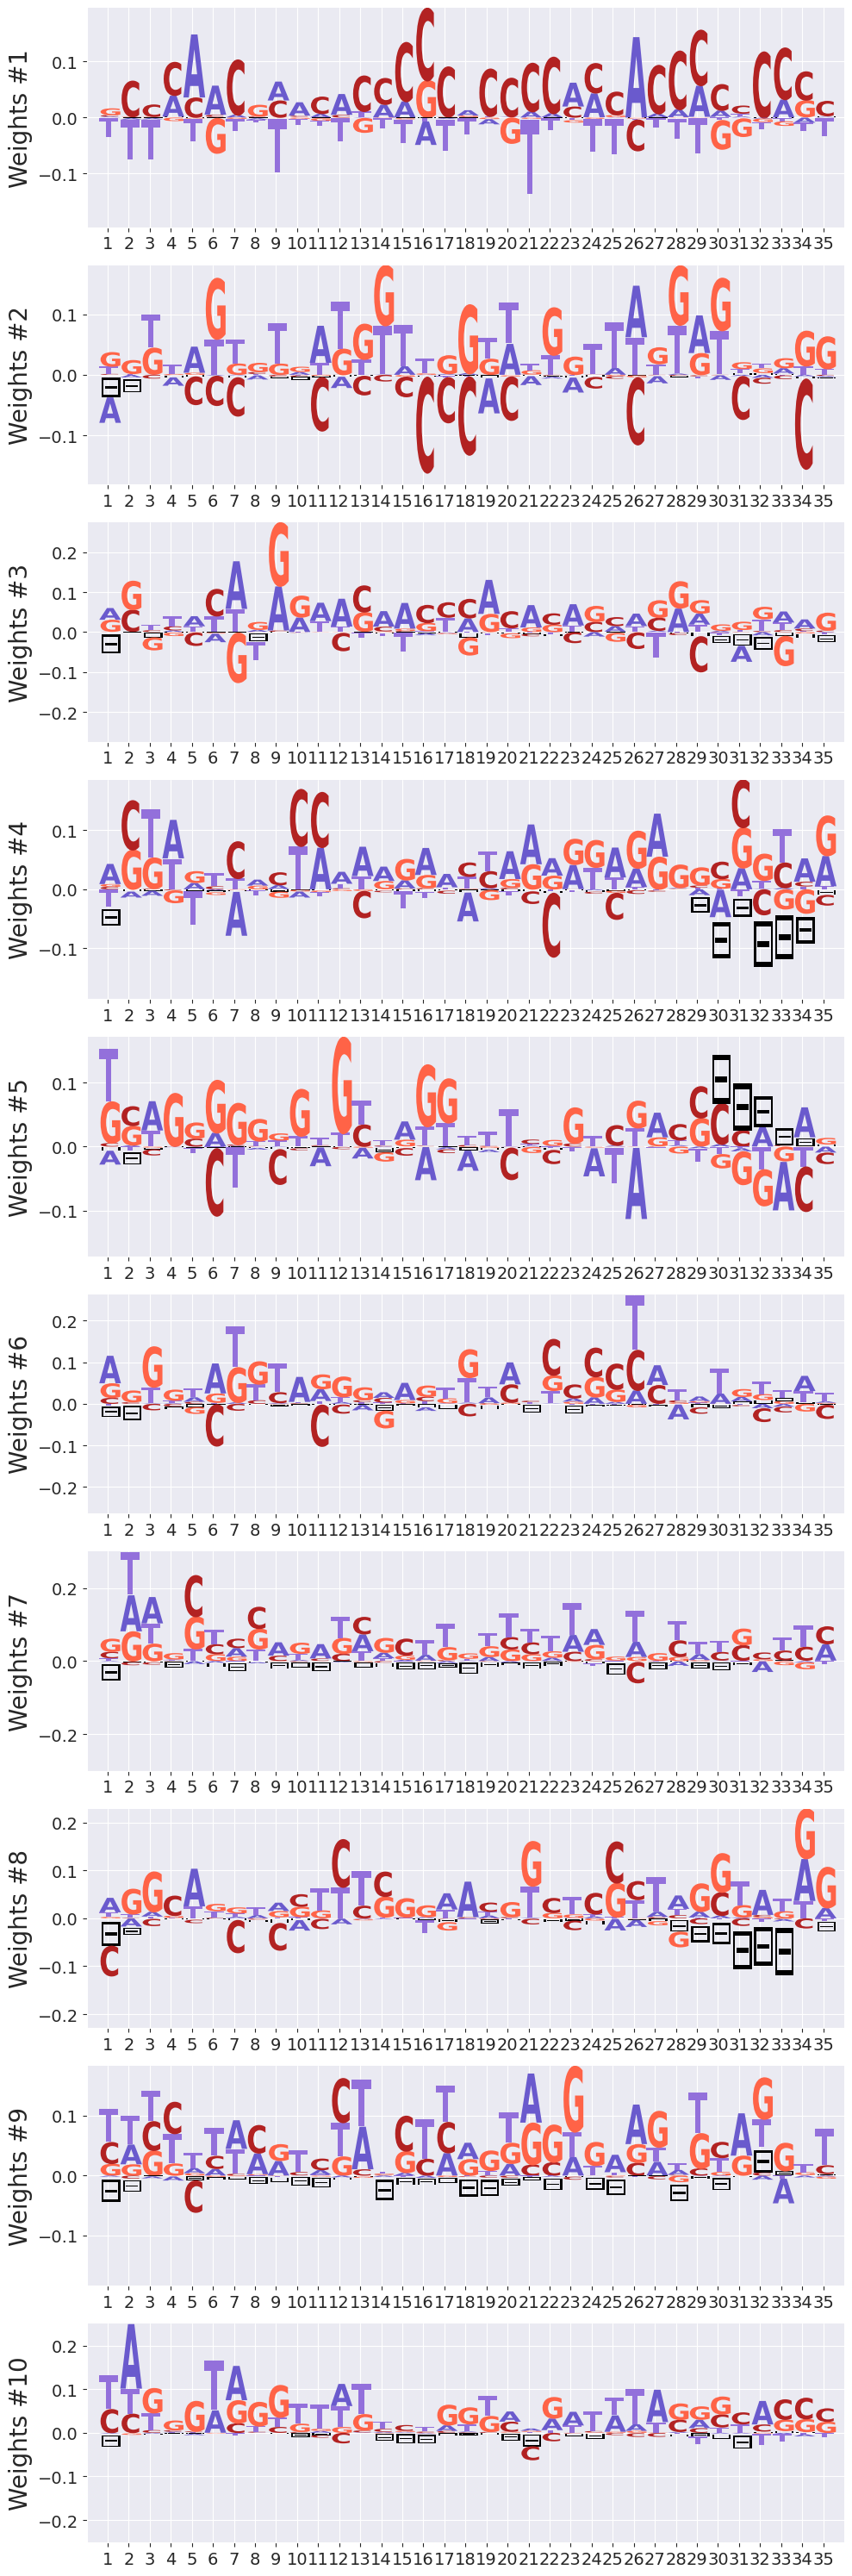

In [13]:
am.view_weights_crbm(c7_crbm, ncrbm.hidden_convolution_keys[0], sort="top", selected=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], molecule="dna")

In [17]:
# calculate likelihoods and fitness values
import torch
# device = torch.device("cpu")
# ncrbm.to(device)
# ncrbm.eval()

am.generate_likelihoods([f"cluster{ci}"], c7_crbm, c7_data, f"c{ci}_likelihoods")
am.generate_likelihoods([f"cluster{ci}"], c7_crbm, c7_data, f"c{ci}_likelihoods_ind", individual_hiddens=True)


In [18]:
# read in generated likelihoods
c7_likelihoods = am.get_likelihoods(f"./generated/c{ci}_likelihoods.json")
c7_likelihoods_ind = am.get_likelihoods(f"./generated/c{ci}_likelihoods_ind.json")

In [19]:
from copy import copy
c7_data["likelihood"] = c7_likelihoods["likelihoods"]["cluster7"]

### Plot Likelihoods of Train, Test, and Val

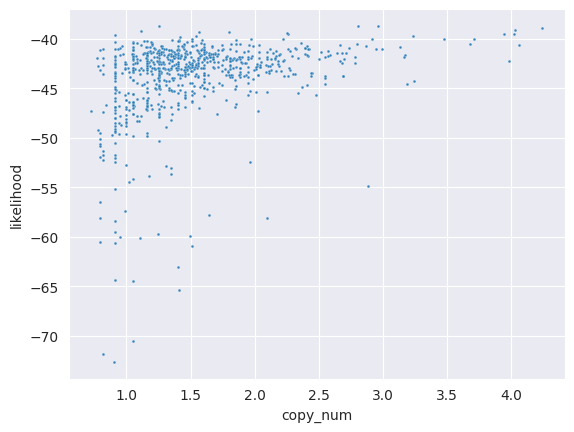

In [22]:
# Compare copy_num (Enrichment Value) vs Model Likelihood

sns.scatterplot(data=c7_data, x="copy_num", y="likelihood", alpha=0.9, s=4)
plt.show()

In [23]:
c7_vout = c7_crbm.compute_output_v(amc.dataframe_to_input(c7_data, c7_crbm.alphabet, c7_crbm.v_num, c7_crbm.q))

c7_vout = torch.concat(c7_vout, dim=1)

X_c7 = c7_vout.detach().numpy()

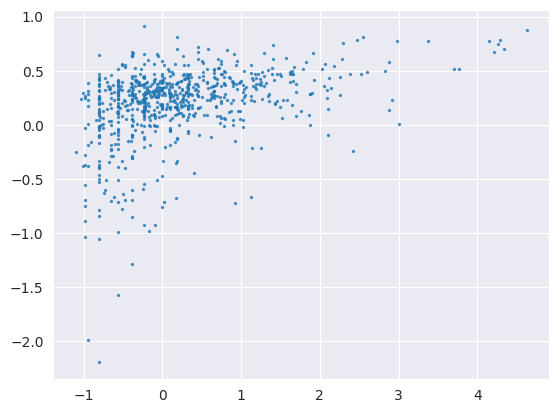

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler

# scaler = QuantileTransformer(output_distribution="uniform")
scaler = RobustScaler()
c7_enrichment = c7_data["copy_num"].to_numpy().reshape(-1, 1)
c7_scaled = scaler.fit_transform(c7_enrichment)
l = LinearRegression(positive=False, fit_intercept=True)
l.fit(X_c7, c7_scaled)

ypred = l.predict(X_c7)

plt.scatter(c7_scaled, ypred, s=2, alpha=0.7)
plt.show()

In [151]:
tmp_df.sort_values("copy_num", ascending=False, inplace=True)
tmp_df.head(2500)

sequence  copy_num  free_energy  cluster
0     CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGGTG  4.238403     7.981091        8
1     CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG  4.057590     8.326882        8
2     CCATTGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG  4.028253    10.016489        8
3     CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGAT  4.017087     8.659055        8
4     CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGCTTGATG  3.983772    10.311282        8
...                                        ...       ...          ...      ...
2494  ATGGGGGGCGGGTTGGGATTGGGGTCGTTTCTACAGTGGG  1.601262    -5.426119        3
2485  CCCCCCCGGGCTTGGGGGGGTGGGTGGGGTGGGGGGTCCT  1.601262   -41.557679        2
2456  CCCCGGCGGGTTGGGGGGGGGGGGTGGGGGGGGGGGGCCT  1.601262   -37.834489        2
2392  TTGGGCTGGGGGGAGGGCAGGGTTCGGGGTCGCTATTGTA  1.601262    -7.278011        0
2496  CCCCCGCCGCCGGGGGGGGGGGGGTGGGGTGGGGGGTCCT  1.601262   -53.183504        2

[2500 rows x 4 columns]

In [158]:
tmp_df["sequence"].iloc[:500]

0      CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGGTG
1      CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG
2      CCATTGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG
3      CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGAT
4      CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGCTTGATG
                         ...                   
500    GCCACGCCGGCTTGGGGGGGGGGGAGGGGTTGGGGGTCCT
498    GCCCGGCGGGCTTGGGGGGGGGGGATGGGTGCGGGGTCCT
494    TCGCGGGGGGCGGGACGGGTGCTCGCTCGAGGGGTCGCAG
497    GCCCCGCGGGCTTGGGGGGGGGGGTTGGGTCGGGGGTCCT
501    GCCCCGCGGGCTGGGGGGGGGGGGTTGGGTCGGGGGTCCT
Name: sequence, Length: 500, dtype: object

In [161]:
from rbm_torch.analysis.secondary_structure import predict_ss

energies, secondary_structures = predict_ss.rnafold_predict_ss(tmp_df["sequence"].iloc[:1000], molecule="dna", gquad=True, tempC=30)

In [162]:
secondary_structures

['(((.(..........).)))....................',
 '(((.(..........).)))....................',
 '(((....((......)))))....................',
 '.(((.(..........).)))...................',
 '.(((.(..........).)))...................',
 '........................................',
 '.(((.(..........).)))...(((...))).......',
 '.(((.(..........).)))...(((...))).......',
 '.++.++.++.++.....+++....+++.+++..+++....',
 '(((....)))..+++++.+++++..+++++.+++++....',
 '.(((+++.+++..+++...........+++.......)))',
 '.((((.(......+++.+++.+++.+++..).))))....',
 '(((....)))...((.+++.+++...+++..+++...)).',
 '(((.(..........).)))....................',
 '((((...))))..+++.+++......+++..+++......',
 '(((((..+++..+++.+++.+++........)))))....',
 '....+++.+++..+++............+++.........',
 '.(((........)))++++.++++.++++..++++.....',
 '.+++.+++.+++..+++.......................',
 '.++.++..++.++......+++.+++..+++...+++...',
 '....+++.+++..+++...+++.....(((...)))....',
 '(((....((......)))))....................',
 '.++.++.+

In [203]:
from nupack import *
def nupack_predict_ss(seqs, molecule="dna", ensemble="stacking", celsius=25, sodium=0.157, magnesium=0.03, forward_primer='', reverse_primer=''):
    no_wildcards = [seq if "N" not in seq and "-" not in seq else False for seq in seqs]
    strands = [Strand(forward_primer+seq+reverse_primer, name=str(i)) for i, seq in enumerate(no_wildcards)]
    model = Model(material=molecule.upper(), celsius=celsius, sodium=sodium, magnesium=magnesium)
    batch_size = 1
    total_batches = math.ceil(len(strands) / batch_size)
    secondary_structures, energies = [], []
    for i in range(len(strands)):
        if i % 2 == 0:
            print(f"Progress {i / (total_batches - 1) * 100}")
        t = Tube(strands={strands[i]: 1e-6}, name="Tube 1")
        tr = tube_analysis(tubes=[t], compute=['mfe'], model=model)
        secondary_structures.append(str(tr[f"({strands[i].name})"].mfe[0].structure))
        energies.append(float(tr[f"({strands[i].name})"].mfe[0].energy))

        ## The below worked prior to 4.0.1.8, can't find a place to report error of course
        # mfe_res = mfe(strands=strands[i], model=model)  # Calculate mfe for all provided sequences
        # secondary_structures.append(mfe_res[0].structure)
        # energies.append(mfe_res[0].energy)

    return energies, secondary_structures

nu_e, nu_ss = nupack_predict_ss(tmp_df["sequence"].iloc[:1000], celsius=25, sodium=0.157, magnesium=0.2, forward_primer='GGGAGAGGAGGGAGATAGATATCAA', reverse_primer='TTTCGTGGATGCCACAGGAC')


Progress 0.0
Progress 0.20020020020020018
Progress 0.40040040040040037
Progress 0.6006006006006006
Progress 0.8008008008008007
Progress 1.001001001001001
Progress 1.2012012012012012
Progress 1.4014014014014013
Progress 1.6016016016016015
Progress 1.8018018018018018
Progress 2.002002002002002
Progress 2.2022022022022023
Progress 2.4024024024024024
Progress 2.6026026026026026
Progress 2.8028028028028027
Progress 3.003003003003003
Progress 3.203203203203203
Progress 3.4034034034034035
Progress 3.6036036036036037
Progress 3.8038038038038042
Progress 4.004004004004004
Progress 4.2042042042042045
Progress 4.404404404404405
Progress 4.604604604604605
Progress 4.804804804804805
Progress 5.005005005005005
Progress 5.205205205205205
Progress 5.405405405405405
Progress 5.605605605605605
Progress 5.805805805805806
Progress 6.006006006006006
Progress 6.206206206206207
Progress 6.406406406406406
Progress 6.606606606606606
Progress 6.806806806806807
Progress 7.007007007007007
Progress 7.2072072072072

In [204]:
nu_ss_trimmed = [x[len('GGGAGAGGAGGGAGATAGATATCAA'):-len('TTTCGTGGATGCCACAGGAC')] for x in nu_ss]

In [205]:
nu_ss_trimmed

['(((.(..........).)))((....))............',
 '(((.(..........).)))((....))............',
 '(((..............)))((....))(....)))))).',
 '((((..........................))))))....',
 '))).............((....)).....(((((......',
 '..............((................))......',
 '))).....................(((...)))..(((..',
 ')))..........(((((....))(....)(((..(((..',
 '................................((.....)',
 '((((...............))))))).........(((((',
 '.(((..(((..(((..........))).....)))..)))',
 '.((((.(.....).)))).................(((((',
 '(((((.(.........).)))))))..........(((((',
 '(((.(..........).)))((....))............',
 '((((...))))))).....................(((((',
 '(((((.(.........).)))))))..........(((((',
 '....(.(((...........))).)...........((.(',
 '.((((.(.....).)))).................(((((',
 '.....(.(((............))).).............',
 '.....................((((........((.....',
 '...............((.((.((((....))..((((...',
 '(((..............)))((....))............',
 '........

In [169]:
s = Strand("CCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGGTG", name="1")

In [187]:
model = Model(material='rna', celsius=37, sodium=0.157, magnesium=0.003)

In [186]:
print(model.alphabet().__str__)

<method-wrapper '__str__' of Alphabet object at 0x7fd3ea66c440>


In [188]:
mfe_res = mfe(strands=s, model=model)

ConversionError: ["not convertible to integer (#0, <class 'str'> → uint32)", "mismatched class type (#0, <class 'str'> → nupack::Base)"]

In [228]:
imp_weights = np.where(np.dot(kmeans_pca.cluster_centers_[8][None, :], components)  > 0.4)[1]

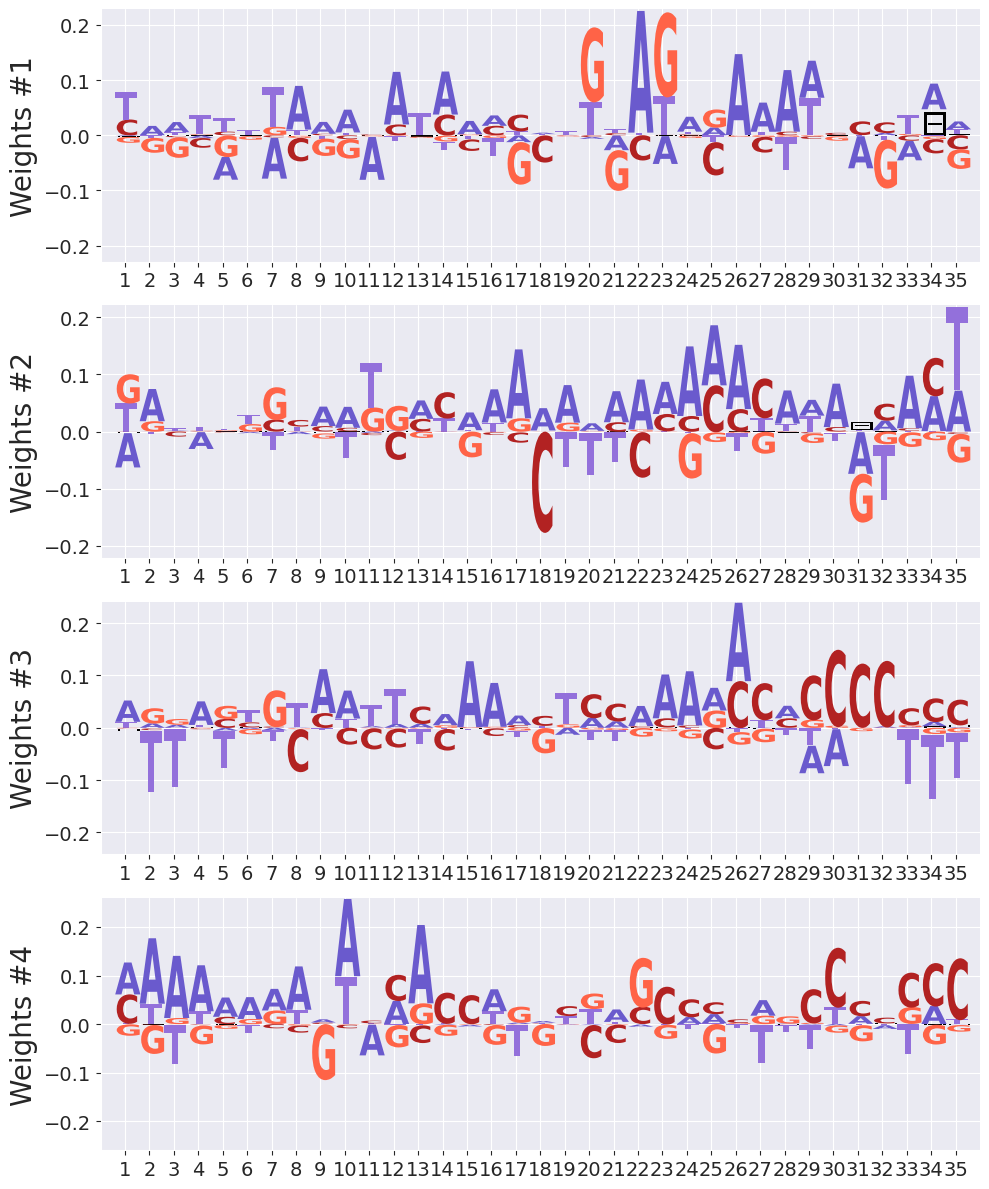

In [229]:
am.view_weights_crbm(ncrbm, ncrbm.hidden_convolution_keys[0], sort="unordered", selected=imp_weights.tolist(), molecule="dna")

In [207]:
X[tmp_df["cluster"] == 8]

array([[ 0.45269284,  0.6862105 ,  0.58394295, ..., -0.25083104,
         0.75424707,  0.7144774 ],
       [ 0.45269284,  0.6862105 ,  0.59149265, ..., -0.25083104,
         0.75424707,  0.7144774 ],
       [ 0.5238499 ,  0.58237916, -0.38181296, ..., -0.32909155,
         0.6889914 ,  0.88709843],
       ...,
       [ 0.5165974 ,  0.70144916,  0.47472036, ...,  1.1752706 ,
         1.0241318 ,  0.9304193 ],
       [ 0.44280094,  0.557486  ,  0.41009253, ...,  0.7472278 ,
         1.2025211 ,  1.08838   ],
       [ 0.4459963 ,  0.6013737 , -0.2849448 , ..., -0.57694143,
         0.97325504,  1.0155959 ]], dtype=float32)

In [32]:
def view_weights_crbm_relu_ax(crbm, hidden_key, weight_number, ax=None, sort="top", molecule="protein", title=None, view="full"):
    beta, W = utils.get_beta_and_W(crbm, hidden_key=hidden_key)
    order = np.argsort(beta)[::-1]
    assert sort in ["top", "unordered"]
    assert molecule in ["protein", "dna", "rna"]
    if sort == "top":
        W = W[order]
        selected_weights = W[weight_number]

    elif sort == "unordered":
        selected_weights = W[weight_number]

    if view == "positive":
        selected_weights = np.maximum(selected_weights, 0.)
    elif view == "negative":
        selected_weights = np.minimum(selected_weights, 0.)

    # Assume we want weights
    fig = utils.Sequence_logo(selected_weights, ax=ax, data_type="weights", title=title, molecule=molecule, ticks_every=5)

def cluster_inputs(I, hidden_unit_2d_combo, padding=0.05, size_to=None, hue_to=None,
                   size_label=None, hue_label=None, ax=None, a=0.7, size_norm=None, hue_norm=None, palette="Set2"):

    # mean = RBM.mean_h(torch.repeat_interleave(I_range.unsqueeze(1), RBM.h_num, dim=1))

    [hidden1, hidden2] = hidden_unit_2d_combo

    if type(I) is torch.tensor:
        I = I.detach().numpy()

    xlab = r'Input $I_{%s}$'%hidden1
    ylab = r'Input $I_{%s}$'%hidden2

    Ih1 = I[:, hidden1]
    Ih2 = I[:, hidden2]

    sns.color_palette(palette, as_cmap=True)
    marker_size = 10

    if size_to is not None and hue_to is None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, size_label: size_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", size=size_label, palette=palette, alpha=a, s=marker_size, ax=ax, hue_norm=hue_norm, size_norm=size_norm)
    elif size_to is None and hue_to is not None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, hue_label: hue_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", hue=hue_label, palette=palette, alpha=a, s=marker_size, ax=ax, hue_norm=hue_norm, size_norm=size_norm)
    elif size_to is not None and hue_to is not None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, size_label: size_to, hue_label: hue_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", size=size_label, palette=palette, hue=hue_label, alpha=a, s=marker_size, ax=ax, hue_norm=hue_norm, size_norm=size_norm)
    else:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", alpha=a, palette=palette, s=marker_size, ax=ax, hue_norm=hue_norm, size_norm=size_norm)

    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.set_xlim([Ih1.min()-padding, Ih1.max()+padding])
    g.set_ylim([Ih2.min()-padding, Ih2.max()+padding])
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)

    # How to make Legend if needed
    # leg = g.axes.flat[0].get_legend()
    # new_title = 'Inputs'
    # leg.set_title(new_title)
    # new_labels = ['label 1', 'label 2']
    # for t, l in zip(leg.texts, new_labels):
    #     t.set_text(l)

    if ax is None:
        plt.show()

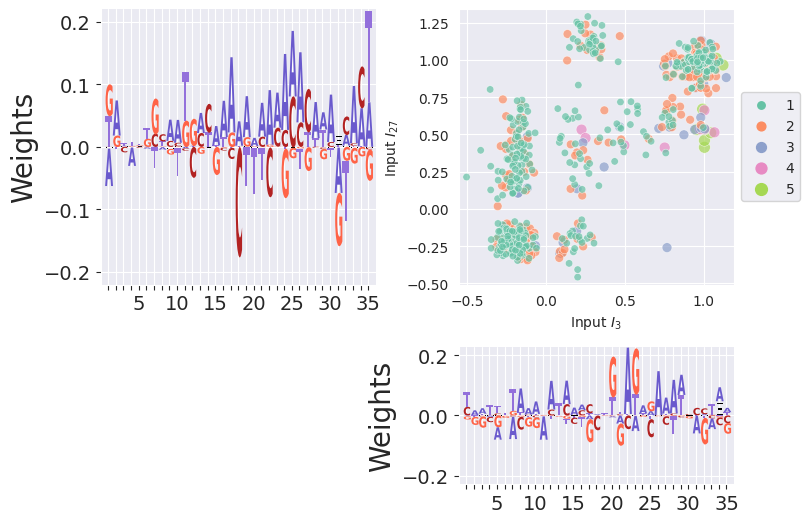

In [226]:
import matplotlib
fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2, 1]})
axs[1][0].axis("off")

view_weights_crbm_relu_ax(ncrbm, ncrbm.hidden_convolution_keys[0], imp_weights[0], sort="unordered", ax=axs[1][1], molecule="dna", view="full")
view_weights_crbm_relu_ax(ncrbm, ncrbm.hidden_convolution_keys[0], imp_weights[1], sort="unordered", ax=axs[0][0], molecule="dna", view="full")

enrichment = pd.cut(tmp_df[tmp_df["cluster"] == 8]["copy_num"], bins=5, labels=[i for i in range(1, 6)])

cluster_inputs(torch.tensor(X[tmp_df["cluster"] == 8]), [imp_weights[0], imp_weights[1]], hue_to=enrichment, hue_label="copy_num", size_to=tmp_df[tmp_df["cluster"]==8]["copy_num"], size_label="copy_num", ax=axs[0][1], hue_norm=matplotlib.colors.BoundaryNorm(boundaries=np.array([0, 1, 2, 3, 4, 5]), ncolors=5)
, size_norm=(0, 5))

fig.subplots_adjust(wspace=0.30, hspace=0.30, left=0.00, right=0.99, top=0.99, bottom=0.0)
plt.show()

In [237]:
w1 = imp_weights[0]
w2 = imp_weights[3]
fig, axs = plt.subplots(2, 2, gridspec={'width_ratios': [1, 1], 'height_ratios': [2, 1]})
axs[1][0].axis("off")

view_weights_crbm_relu_ax(ncrbm, ncrbm.hidden_convolution_keys[0], w1, sort="unordered", ax=axs[1][1], molecule="dna", view="full")
view_weights_crbm_relu_ax(ncrbm, ncrbm.hidden_convolution_keys[0], w2, sort="unordered", ax=axs[0][0], molecule="dna", view="full")

enrichment = pd.cut(tmp_df[tmp_df["cluster"] == 8]["copy_num"], bins=5, labels=[i for i in range(1, 6)])

cluster_inputs(torch.tensor(X[tmp_df["cluster"] == 8]), [w1, w2], hue_to=enrichment, hue_label="copy_num", size_to=tmp_df[tmp_df["cluster"]==8]["copy_num"], size_label="copy_num", ax=axs[0][1], hue_norm=matplotlib.colors.BoundaryNorm(boundaries=np.array([0, 1, 2, 3, 4, 5]), ncolors=5)
, size_norm=(0, 5))

fig.subplots_adjust(wspace=0.30, hspace=0.30, left=0.00, right=0.99, top=0.99, bottom=0.0)
plt.savefig("clustout.png")

/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (934). n_quantiles is set to n_samples.
  warnings.warn(


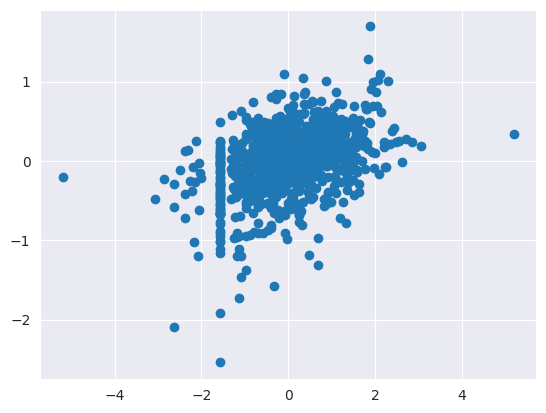

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

c8_input = X[tmp_df["cluster"] == 8]
scaler = QuantileTransformer(output_distribution="normal")
c8_enrichment = tmp_df[tmp_df["cluster"] == 8]["copy_num"].to_numpy().reshape(-1, 1)
c8_scaled = scaler.fit_transform(c8_enrichment)
l = LinearRegression(positive=False, fit_intercept=True)
l.fit(c8_input, c8_scaled)

ypred = l.predict(c8_input)

plt.scatter(c8_scaled, ypred)
plt.show()

In [28]:
np.argwhere(l.coef_[0] > 0.5).tolist()

array([[ 0],
       [23],
       [24],
       [46],
       [59],
       [77],
       [78]])

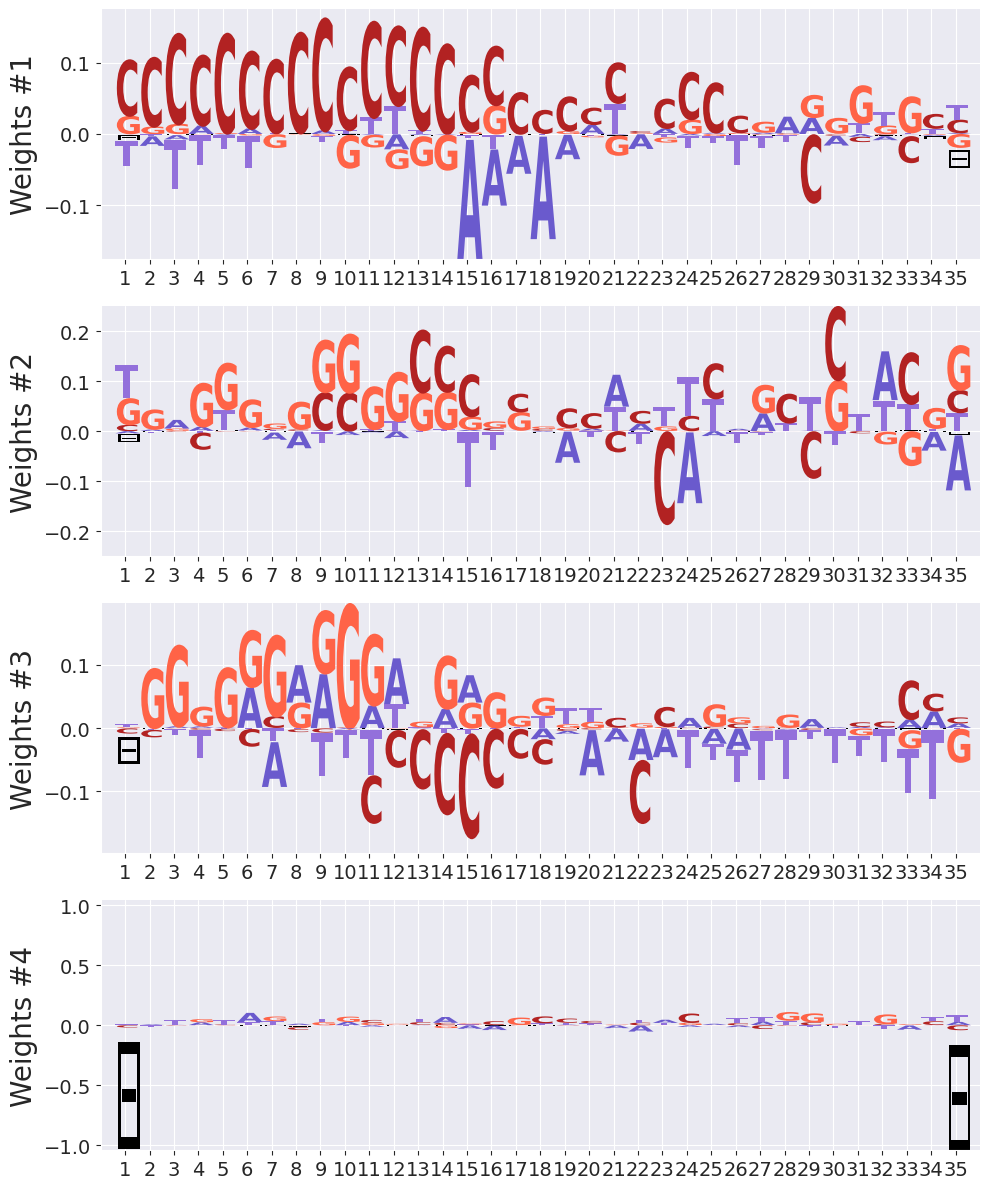

In [55]:
am.view_weights_crbm(ncrbm, ncrbm.hidden_convolution_keys[0], sort="unordered", selected=np.argpartition(l.coef_[0], -4)[-4:].tolist(), molecule="dna")

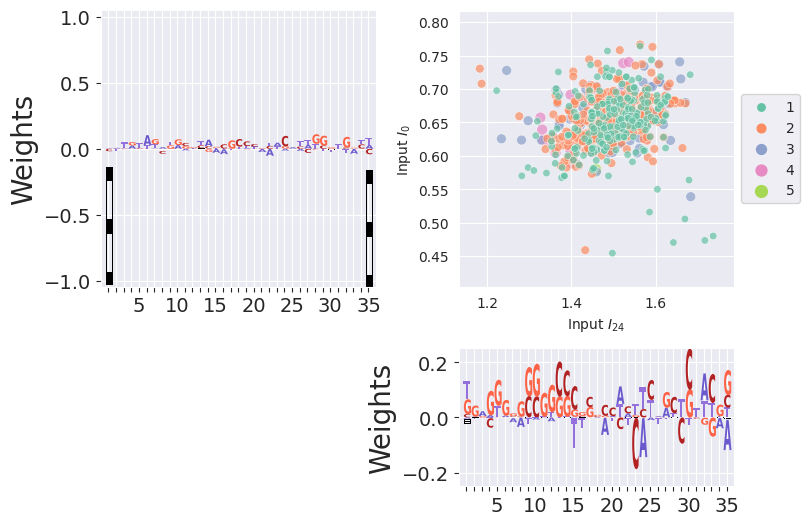

In [60]:
import matplotlib.pyplot as plt
mi_weights = np.argpartition(l.coef_[0], -4)[-4:].tolist()
# mi_weights = np.arg(l.coef_[0] > 0.5).tolist()

w1 = mi_weights[1]
w2 = mi_weights[3]

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2, 1]})
axs[1][0].axis("off")

view_weights_crbm_relu_ax(ncrbm, ncrbm.hidden_convolution_keys[0], w1, sort="unordered", ax=axs[1][1], molecule="dna",
                          view="full")
view_weights_crbm_relu_ax(ncrbm, ncrbm.hidden_convolution_keys[0], w2, sort="unordered", ax=axs[0][0], molecule="dna",
                          view="full")

enrichment = pd.cut(tmp_df[tmp_df["cluster"] == 8]["copy_num"], bins=5, labels=[i for i in range(1, 6)])

cluster_inputs(torch.tensor(X[tmp_df["cluster"] == 8]), [w1, w2], hue_to=enrichment, hue_label="copy_num",
               size_to=tmp_df[tmp_df["cluster"] == 8]["copy_num"], size_label="copy_num", ax=axs[0][1], size_norm=(0, 5))

fig.subplots_adjust(wspace=0.30, hspace=0.30, left=0.00, right=0.99, top=0.99, bottom=0.0)
plt.show()

In [39]:
w2

[23]

In [ ]:
import matplotlib.pyplot as plt

mapp = enriched2_data["copy_num"] > 1
data = e2_comb_input[mapp]
fold = enriched2_data[mapp]["copy_num"].tolist()
likeli = enriched2_data[mapp]["enrich2_1c_st likelihood"].tolist()
segment = enriched2_data[mapp]["segment"].tolist()

input_positions = [0,1]

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2, 1]})

axs[1][0].axis("off")
view_weights_crbm_ax(e1c_crbm, "hidden_20", input_positions[0], sort="top", ax=axs[1][1], molecule="dna", view="full")
view_weights_crbm_ax(e1c_crbm, "hidden_20", input_positions[1], sort="top", ax=axs[0][0], molecule="dna", view="full")
cluster_inputs(torch.tensor(data), input_positions, size_to=fold, hue_to=likeli,
                 size_label="fold", hue_label="Likelihood", size_norm=(1, 50), a=0.6, ax=axs[0][1])
fig.subplots_adjust(wspace=0.30, hspace=0.30, left=0.00, right=0.99, top=0.99, bottom=0.0)
plt.show()

In [129]:
np.dot(train_ind, components[component]).shape

(11255,)

In [81]:
kmeans_pca.labels_.tolist().index(2)

9

In [80]:
kmeans_pca.labels_.tolist()

[8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 2,
 0,
 2,
 2,
 8,
 2,
 2,
 0,
 2,
 0,
 0,
 8,
 8,
 0,
 8,
 8,
 2,
 8,
 8,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 9,
 2,
 8,
 2,
 8,
 2,
 7,
 4,
 2,
 2,
 2,
 8,
 2,
 2,
 0,
 7,
 2,
 2,
 8,
 2,
 2,
 2,
 2,
 8,
 9,
 4,
 2,
 7,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 8,
 8,
 2,
 2,
 0,
 8,
 0,
 8,
 7,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 0,
 0,
 2,
 2,
 2,
 0,
 7,
 2,
 3,
 8,
 2,
 2,
 2,
 2,
 0,
 2,
 4,
 0,
 8,
 8,
 8,
 8,
 8,
 2,
 7,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 8,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 7,
 2,
 4,
 2,
 2,
 7,
 7,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 8,
 1,
 2,
 0,
 3,
 8,
 2,
 9,
 8,
 2,
 2,
 8,
 2,
 8,
 8,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 0,
 2,
 0,
 4,
 4,
 2,
 2,
 2,
 2,
 8,
 2,
 0,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 0,
 2,
 2,
 9,
 2,
 2,
 2,
 8,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 7,
 2,
 4,
 0,


In [61]:
np.array(am.supported_colors)[kmeans_pca.labels_]

array(['c', 'c', 'c', ..., 'violet', 'k', 'k'], dtype='<U11')

In [22]:
np.where(components[7] < 0)

(array([ 2,  3,  4,  6,  7, 10, 15, 18, 20, 22, 23, 27, 30, 35, 37, 38, 39,
        42, 46, 49, 52, 55, 57, 61, 62, 63, 67, 70, 71, 72, 73, 74, 76, 78,
        79]),)

# Evaluation on Test Set of Sequences

In [29]:
import test_seqs as ts

t1 = ts.generate_test_set(set_nuc="-")
t2 = ts.generate_test_set(set_nuc="-")
t3 = ts.generate_test_set(set_nuc="-")
# t1_likelis = ncrbm.predict(t1)
# t2_likelis = ncrbm.predict(t2)
# t3_likelis = ncrbm.predict(t3)
t1_likelis = eval_ncrbm.predict(t1)
t2_likelis = eval_ncrbm.predict(t2)
t3_likelis = eval_ncrbm.predict(t3)
t1["t1_likelihood"] = t1_likelis[1]
t1["t2_likelihood"] = t2_likelis[1]
t1["t3_likelihood"] = t3_likelis[1]

t1

name                                  sequence  fluorescence  \
0   SP5_sup  ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT       1500.00   
1   SP5_pap  AACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTTG       1500.00   
2       SP6  CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT       2500.00   
3   SP7_sup  CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT       2750.00   
4   SP7_pap  TAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT       2750.00   
5      SP6C  CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT         45.00   
6     SP634  CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGGCCTAG       2250.00   
7    SP634G  CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGCCACTA         10.00   
8    SP634C  CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTGTAT         10.00   
9    SP634A  CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAACT         50.00   
10    SP630  ACTCATGGTAGGTATTGCATGGTAGGGATAGTGATCTAAT        500.00   
11    SP619  TAATGGTCATAGTATTGCATGGTAGGGATAGGACACCGCC         10.00   
12     RBD1  AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT        178.60   
13     RBD2  GTTAGGTTCTGGATTAGGTTAGGGTTGTGTTGTTGTTAGG        196.42   
14     RBD3  TACAGTTGGTTGTAGGTTTTTGTTAGGTTAGTTTAGGGTT        214.42   
15     RBD4  TGGGTGTTTTGGTTGTAGGGTTTAGGTTTAGGGTACTCTT        392.82   

    t1_likelihood  t2_likelihood  t3_likelihood  
0       28.484314      28.484314      28.484314  
1       22.627701      22.627701      21.722366  
2       29.827637      29.827637      29.827637  
3       27.623871      27.623871      27.623871  
4       32.451111      32.683731      32.170380  
5       28.087173      28.087173      28.087173  
6       18.228210      22.721970      25.486694  
7       19.819992      19.802963      21.749039  
8       26.106461      24.552429      20.283081  
9       20.293808      20.366806      17.658981  
10      21.200073      18.766739      19.047241  
11       0.331192      -0.601410       5.359436  
12      32.248642      32.248642      32.248642  
13       2.217590       2.217590       2.217590  
14      12.025864      12.025864      12.025864  
15       8.277542       8.277542       8.277542

# Generating New Sequences

In [5]:
from rbm_torch.utils import seq_utils as su

# MC Sampling @ Low Temperature
gseqs_low_2, ghiddens_low_2 = utils.gen_data_lowT(ncrbm, beta=2, which = 'marginal' ,Nchains=200, Lchains=300, Nthermalize=500, Nstep=10, N_PT=20, reshape=True, update_betas=False)
gseqs_low_3, ghiddens_low_3 = utils.gen_data_lowT(ncrbm, beta=3, which = 'marginal' ,Nchains=200, Lchains=300, Nthermalize=500, Nstep=10, N_PT=20, reshape=True, update_betas=False)
# gseqs_low_1, ghiddens_low_1 = utils.gen_data_lowT(ncrbm, beta=1, which = 'marginal' ,Nchains=100, Lchains=200, Nthermalize=300, Nstep=5, N_PT=10, reshape=True, update_betas=False)

# Convert to Readable Format
gen_seqs_low_3 = su.cat_to_seq(gseqs_low_3.detach().argmax(-1).numpy(), molecule=ncrbm.molecule)
gen_seqs_low_2 = su.cat_to_seq(gseqs_low_2.detach().argmax(-1).numpy(), molecule=ncrbm.molecule)

# Put into Dataframe
low_3_seqs_pd = pd.DataFrame({"sequence": gen_seqs_low_3})
low_2_seqs_pd = pd.DataFrame({"sequence": gen_seqs_low_2})

# Drop duplicates
low_3_seqs_pd.drop_duplicates(subset="sequence", inplace=True)
low_2_seqs_pd.drop_duplicates(subset="sequence", inplace=True)

# Evaluate Model Likelihood
low_3_likelis = ncrbm.predict(low_3_seqs_pd)
low_2_likelis = ncrbm.predict(low_2_seqs_pd)

# Put into Dataframe
low_3_seqs_pd["likelihood"] = low_3_likelis[1]
low_2_seqs_pd["likelihood"] = low_2_likelis[1]

low_3_seqs_pd.to_csv("cov_enriched_low3_0.csv")
low_2_seqs_pd.to_csv("cov_enriched_low3_2.csv")

In [6]:
# MC Sampling @ Low Temperature
gseqs_low_2, ghiddens_low_2 = utils.gen_data_lowT(ncrbm, beta=2, which = 'marginal' ,Nchains=200, Lchains=300, Nthermalize=500, Nstep=10, N_PT=20, reshape=True, update_betas=False)
# gseqs_low_3, ghiddens_low_3 = utils.gen_data_lowT(ncrbm, beta=3, which = 'marginal' ,Nchains=200, Lchains=300, Nthermalize=500, Nstep=10, N_PT=20, reshape=True, update_betas=False)
gseqs_low_1, ghiddens_low_1 = utils.gen_data_lowT(ncrbm, beta=1, which = 'marginal' ,Nchains=200, Lchains=300, Nthermalize=500, Nstep=10, N_PT=20, reshape=True, update_betas=False)

# Convert to Readable Format
gen_seqs_low_3 = su.cat_to_seq(gseqs_low_3.detach().argmax(-1).numpy(), molecule=ncrbm.molecule)
gen_seqs_low_2 = su.cat_to_seq(gseqs_low_2.detach().argmax(-1).numpy(), molecule=ncrbm.molecule)

# Put into Dataframe
low_3_seqs_pd = pd.DataFrame({"sequence": gen_seqs_low_3})
low_2_seqs_pd = pd.DataFrame({"sequence": gen_seqs_low_2})

# Drop duplicates
low_3_seqs_pd.drop_duplicates(subset="sequence", inplace=True)
low_2_seqs_pd.drop_duplicates(subset="sequence", inplace=True)

# Evaluate Model Likelihood
low_3_likelis = ncrbm.predict(low_3_seqs_pd)
low_2_likelis = ncrbm.predict(low_2_seqs_pd)

# Put into Dataframe
low_3_seqs_pd["likelihood"] = low_3_likelis[1]
low_2_seqs_pd["likelihood"] = low_2_likelis[1]

low_3_seqs_pd.to_csv("cov_enriched_low3_1.csv")
low_2_seqs_pd.to_csv("cov_enriched_low2_1.csv")

In [5]:
start = 2
for _ in range(3):
    for i in [1, 2, 3]:
        gseqs_low, ghiddens_low = utils.gen_data_lowT(ncrbm, beta=i, which = 'marginal' ,Nchains=1000, Lchains=1000, Nthermalize=800, Nstep=500, N_PT=2000, reshape=True, update_betas=False)

        gen_seqs_low = su.cat_to_seq(gseqs_low.detach().argmax(-1).numpy(), molecule=ncrbm.molecule)
        # Put into Dataframe
        low_seqs_pd = pd.DataFrame({"sequence": gen_seqs_low})
        # Drop duplicates
        low_seqs_pd.drop_duplicates(subset="sequence", inplace=True)
        # Evaluate Model Likelihood
        low_likelis = ncrbm.predict(low_seqs_pd)
        # Put into Dataframe
        low_seqs_pd["likelihood"] = low_likelis[1]
        # Save
        low_seqs_pd.to_csv(f"cov_enriched_low{i}_{start}.csv")
        start += 1

KeyboardInterrupt: 

In [32]:
low_1_seqs_pd.to_csv("cov_enriched_low1_v27.csv")
low_2_seqs_pd.to_csv("cov_enriched_low2_v27.csv")

### Plot Likelihoods of Generated Data

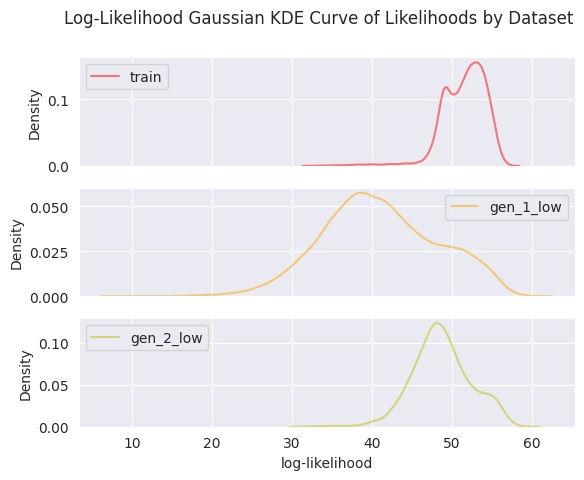

In [33]:
joined_likelihoods = {"train":ncrbm_likelihoods["likelihoods"]["train"], "gen_1_low": low_1_likelis[1], "gen_2_low": low_2_likelis[1]}

labels = list(joined_likelihoods.keys())

am.plot_likelihoods(joined_likelihoods, labels, labels, xlim=None, cdf=False)

## Alternatively

In [39]:
# Generate Data by the cluster hidden inputs

from copy import deepcopy

cluster_labels = kmeans_pca.fit_predict(X)

cluster = 5
cluster_indx = np.where(cluster_labels == cluster)[0]
samples = 1000

_ = ncrbm.compute_output_v(amc.dataframe_to_input(train_data, am.int_to_letter_dicts[ncrbm.molecule], ncrbm.v_num, ncrbm.q))
orig_max_inds = deepcopy(ncrbm.max_inds)
# prep
max_inds = []
for mi in ncrbm.max_inds:
    minp = mi.squeeze(2).detach().numpy()
    max_inds.append(minp[cluster_indx])

muniq = []
for mi in max_inds:
    muniq.append(np.unique(mi, return_counts=True, axis=0))


# sampling
ht_c = []
if type(train_vout) is not list:
    train_vout = [train_vout]

for ht in train_vout:
    htc = ht[torch.tensor(cluster_indx)]
    # ht_c.append(ht[torch.tensor(cluster_indx)])
    htc_m = htc.mean(0)
    htc_s = htc.std(0)
    ht_c.append((htc_m, htc_s))

rand_mi = []
for i in range(len(max_inds)):
    rand_mi.append(torch.tensor(max_inds[i][np.random.choice(np.arange(muniq[i][0].shape[0]), samples, p=muniq[i][1]/sum(muniq[i][1]))]).unsqueeze(2))

ncrbm.max_inds = rand_mi

h_samples = []
for h in ht_c:
    h_samples.append(h[0] + torch.randn((samples, 1)) * h[1])

oh_samples = ncrbm.sample_from_inputs_v(ncrbm.compute_output_h(h_samples))

ncrbm.max_inds = orig_max_inds

/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
from rbm_torch.utils import seq_utils as su
gen_seqs_clust_5 = su.cat_to_seq(oh_samples.detach().argmax(-1).numpy(), molecule=ncrbm.molecule)

In [41]:
gen_seqs_clust_5

['GCCA-CGAGCAAAACCTCTGG--TT-CT-AGTA-AAC-GA',
 'CCACCATGATGCAA--TAACGG-CAGTGGGGTCAGGA-CC',
 'AGAATGG-ACAGGA-GCGAGGATCGGTC-AAAGCATGGA-',
 '-AACTTT-C-A-GT-ATGTGTTTTTGGG--GC-ACG--AG',
 '-CTAGGA-ATGG-TAATGTCATGGG-G-CGC--CTCGG-T',
 'TGCAG-CAGAT-CCCATTGTTG-CACACGGTAATTG-G-A',
 'CCACG--GC-GATTTCC--AGTC-GATTACACT-CGGTCG',
 'TAGCCTCAGAATTAA-T--GGGACC-CT-CAAAC--AC-A',
 'AAT-TCA-G-TG-AGTTCCC--TGT--CG--AGAAAGGTA',
 'CCC-G--GG-CCGC--AGAAGAAT-TAATATCGA-TGTAT',
 '-C---CCTC--GGGCACT-GAG-G-AGGGTGT-GA-CT-T',
 'GTCCGCTCGTT-ATA-G-GGT--C-GA-GAGCTGCCACTT',
 'GGAC--TGTGGAA--A-GCGGAGGTCCATTAGTGTATAAA',
 'CGGC-CGT-CA-ACCCT-GTC-AGATGGAATGCG-CGT-C',
 'GAGCGAGC-GC-G-TGACCTGAACAGCCGA-CGT-GGCC-',
 'TTTG-ATCG-T-AGGACTT--GTTGACTTA-AAA-TCCTA',
 'GTA-GCT-T-AGCCACA-GTCGCCCGC-TCCGAC-GGCTA',
 'TAA-TCA-GTTAAAACGAACCTTGC-GGATGAC-CG-CCT',
 'TG-G-ACGGCCTGG---TCAAACAAA-A-C--GCTGGTGT',
 'GAG--GGGCA-CCCTGCC-TATG-ATCTGCTATTTGTTTA',
 'GGTACGACC-C-TTCGG-G-GGAAGGATGCGTCGGCA---',
 'ACG-GCTTC-TCCGCCGGTCGGTTCTGC-T-TTC-CCGCC',
 'GGAAAACT

# Evaluating Generated Sequences by Likelihood, Cluster Identity and Secondary Structure Prediction

In [43]:
kmeans_pca.cluster_centers_

array([[ 7.2846645e-01, -3.9846373e-01, -1.4782828e-01,  2.5343224e-01,
         9.0520173e-02,  4.1609293e-01,  2.4203379e-01, -4.0170833e-01,
         4.6494317e-01, -9.9865532e-01,  1.2450985e+00,  4.4636324e-02,
         1.6240612e+00, -1.0693669e+00, -7.8734988e-01,  1.5759267e-01,
        -1.0736556e+00,  4.8298243e-01,  1.0116009e+00,  3.2212612e-01,
        -2.4411868e-01, -8.5736644e-01, -3.7329230e-01,  1.3208554e+00,
         6.2497910e-02],
       [-9.0293956e-01, -4.3156278e-01,  1.5688175e-01,  8.2668000e-01,
        -1.0124519e+00, -8.7350196e-01,  5.7699227e-01, -3.5215044e-01,
         1.9104512e+00,  4.3494761e-01,  6.1037248e-01,  1.0100020e+00,
        -1.6955042e-01,  7.3319614e-01, -4.7053969e-01, -5.4864734e-01,
        -1.1231608e+00, -4.3345189e-01,  1.0623873e+00, -7.7572870e-01,
        -8.2558727e-01,  7.2704434e-01,  1.2736405e+00, -3.9667529e-01,
        -2.1355142e-01],
       [-2.0445134e-01,  1.1038982e+00, -5.4678452e-01,  1.2043903e-01,
         2.891

In [46]:
gseqs_low_1

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]],

        ...,

        [[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         

In [47]:
low_1_vout = ncrbm.compute_output_v(gseqs_low_1)
low_2_vout = ncrbm.compute_output_v(gseqs_low_2)

In [60]:
# Get distance b/t each cluster center for each sequence
cdists = torch.cdist(torch.tensor(kmeans_pca.cluster_centers_).unsqueeze(0), torch.concat(low_2_vout, dim=1).unsqueeze(0))


# Use distances to constrain to be closer


In [74]:
cdists.shape

torch.Size([1, 10, 20000])

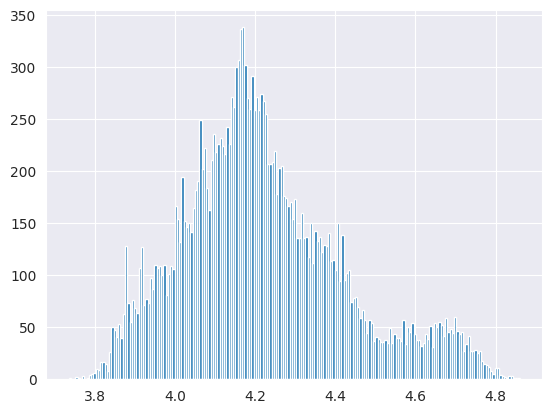

In [63]:
import matplotlib.pyplot as plt

plt.hist(cdists[0].min(dim=0)[0].detach().numpy(), bins=200)
plt.show()

In [67]:
ht_c

[(tensor([ 0.5459,  0.9512,  0.5264,  0.6871,  1.2427,  0.7460,  0.7661, -0.1401,
           0.5432,  0.5084,  0.3971, -0.1035,  0.6633,  0.8589,  0.6904,  0.5777,
           0.8120,  0.7701, -0.0502,  0.7128,  0.5546,  0.5549,  0.8278,  0.6464,
           1.1195], grad_fn=<MeanBackward1>),
  tensor([0.0778, 0.0794, 0.0414, 0.1151, 0.1548, 0.0536, 0.0527, 0.2103, 0.0600,
          0.0747, 0.1100, 0.1072, 0.0621, 0.0451, 0.0409, 0.0697, 0.0481, 0.1217,
          0.2152, 0.0652, 0.0502, 0.0844, 0.0355, 0.0559, 0.1226],
         grad_fn=<StdBackward0>))]

In [70]:
cdists[0][0]

tensor([5.3631, 5.4236, 5.3696,  ..., 4.7113, 4.7403, 4.7662],
       grad_fn=<SelectBackward0>)

In [71]:
train_vout[]

[tensor([[ 0.8961,  0.6711,  0.3793,  ...,  0.8606,  0.6050,  0.9893],
         [ 0.9007,  0.6835,  0.4124,  ...,  0.8378,  0.6016,  0.9437],
         [ 0.8961,  0.6504,  0.3793,  ...,  0.8606,  0.6050,  0.9684],
         ...,
         [ 0.4094,  1.2474,  0.4869,  ...,  0.9590,  0.6621, -0.1635],
         [ 0.4575,  1.2552,  0.4897,  ...,  0.9987,  0.6214, -0.2665],
         [ 0.4506,  1.2552,  0.4896,  ...,  0.9987,  0.5963, -0.2665]],
        grad_fn=<CatBackward0>)]

In [1]:
cluster_labels

NameError: name 'cluster_labels' is not defined